# Overview of "data available upon request" statements in the PMC open access corpus

This notebook documents the main descriptive analyses of "data available upon request" statements in a large corpus of PubMed Central (PMC) open access articles. It is intended as a fully reproducible supplement to the manuscript, and focuses on three questions:

1. How frequent are “upon request” statements across time and journals in the PMC Open Access subset?
2. Among these statements, which ones correspond to genuine data access routes (eg. patients, plasmids) versus vague or restrictive formulations (eg. raw data but not processed data)?
3. How have changes in data-sharing policies and methods-reporting standards shaped the use of “data available upon request” in the literature?

All analyses are performed on a pre computed metadata table, `meta_under_request_tagged.tsv`, derived from the main text mining pipeline.


### Fixing the classic Matplotlib “Type 3 fonts” issue. 
The fix is to force Matplotlib to embed TrueType fonts (Type 42) in PDFs.

In [370]:
# Fixing the classic Matplotlib “Type 3 fonts” issue. The fix is to force Matplotlib to embed TrueType fonts (Type 42) in PDFs.

import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler

# Use TrueType fonts in PDF/EPS so text is selectable and non-broken in Acrobat
# Make PDF text selectable as normal text (not one glyph per letter)
matplotlib.rcParams["pdf.fonttype"] = 42   # Use TrueType fonts in PDFs
matplotlib.rcParams["ps.fonttype"] = 42    # Same for EPS, just in case
matplotlib.rcParams["text.usetex"] = False # Ensure we are not using LaTeX rendering


# Font: journal style sans-serif
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial", "Helvetica"]

# General sizes
mpl.rcParams["font.size"] = 9            # base
mpl.rcParams["axes.titlesize"] = 10
mpl.rcParams["axes.labelsize"] = 9
mpl.rcParams["xtick.labelsize"] = 8
mpl.rcParams["ytick.labelsize"] = 8
mpl.rcParams["legend.fontsize"] = 8

# Figure quality
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["figure.autolayout"] = False  # we usually call tight_layout() manually

# Axes style
mpl.rcParams["axes.linewidth"] = 0.8
mpl.rcParams["axes.edgecolor"] = "black"
mpl.rcParams["xtick.direction"] = "out"
mpl.rcParams["ytick.direction"] = "out"
mpl.rcParams["xtick.major.size"] = 3
mpl.rcParams["ytick.major.size"] = 3
mpl.rcParams["grid.linestyle"] = ":"
mpl.rcParams["grid.linewidth"] = 0.5

# Colorblind friendly qualitative palette (Okabe-Ito)
okabe_ito = [
    "#0072B2",  # blue
    "#D55E00",  # vermillion (orange-ish)
    "#009E73",  # bluish green
    "#CC79A7",  # reddish purple
    "#F0E442",  # yellow
    "#56B4E9",  # sky blue
    "#E69F00",  # orange
    "#000000",  # black
]
tol_qualitative = [
    "#332288",  # dark blue
    "#117733",  # dark green
    "#44AA99",  # teal
    "#88CCEE",  # light turquoise
    "#DDCC77",  # sand
    "#CC6677",  # rose
    "#AA4499",  # purple
    "#882255",  # wine
]
muted_scientific = [
    "#1b9e77",  # green
    "#d95f02",  # orange
    "#7570b3",  # purple
    "#e7298a",  # pink
    "#66a61e",  # olive green
    "#e6ab02",  # mustard
    "#a6761d",  # brown
    "#666666",  # gray
]

#mpl.rcParams["axes.prop_cycle"] = cycler(color=okabe_ito)
#mpl.rcParams["axes.prop_cycle"] = cycler(color=tol_qualitative)
mpl.rcParams["axes.prop_cycle"] = cycler(color=muted_scientific)


## Upstream text mining pipeline and input data

This notebook does not rerun the full text mining pipeline, but uses its outputs. The key upstream steps are:

1. **PMC and journal selection**  
   We began from the PMC Open Access subset, restricted to a predefined set of journals and years. Metadata for all candidate articles were retrieved using `01_fetch_metadata_allpapers_monthly.py`, and filtered down to the PMC open access subset with `02_filter_openaccess_subset.py`.

2. **Full text download and XML quality control**  
   Open access XML full texts were fetched from the PMC FTP and related endpoints (`03_download_papers_oai.py` and `03_download_papers_no_cc.py`). XML integrity was assessed with `04_validate_xml_integrity.py`, invalid XMLs were removed using `05_remove_invalid_xmls.sh`, and the metadata table was enriched with XML status flags via `06_enrich_tsv_xml_status.py`.

3. **Detection of "upon request" statements**  
   Candidate "data available upon request" phrases were extracted from the JATS XML using `07_parse_under_request_with_sections_restricted.py`. This parser scans all sections and records, for each article, whether at least one phrase matches a curated phrase list, in which section(s) it occurs, and whether the phrase appears in context of restricted access keywords (for example, "data sharing agreement", "patient privacy", "controlled access"). `meta_under_request.tsv` is the output of the parser.

4. **Classification into genuine and restricted statements**  
   The initial parse flags were refined by `08_tag_under_request_compliance.py`, which uses a set of deterministic rules and cue words to distinguish:
   - **genuine "upon request" statements**, where data or materials are actually intended to be shared (genuine == 1),
   - from **restricted access statements**, where access is limited by legal, ethical, or administrative constraints (restricted == 1),
   - and from **ambiguous or non data related uses** of the phrase (genuine == 0 and restricted == 0).

The output of these steps is the metadata table `meta_under_request_tagged.tsv`, which is the sole input used in this notebook. Each row corresponds to one PMC article and contains, among others, the columns:

- `journal`  
- `pub_year`  
- `ok_analysis` (1 if the article passed all XML checks and could be analysed)  
- `under_request` (final binary flag for presence of at least one "upon request" statement)  
- `genuine` (1 if the statement is judged to be a genuine data sharing route)  
- `restricted_initial_parse`, `restricted` (initial parser flag and final restricted flag)  
- `section_under_request` and `phrase` (section and literal matched phrase).
  

### Loading the TSV files and params
*   Some basic plotting defaults
*   Years to display
*   Data dirs and files
*   Output folders

In [371]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Some basic plotting defaults
matplotlib.rcParams["font.size"] = 10

# Years to display
YEAR_MIN, YEAR_MAX = 2010, 2025

# This notebook lives in 1.scripts/07_plots
notebook_dir = Path.cwd()
print("Notebook dir:", notebook_dir)

# Project root is one level above 1.scripts
project_root = notebook_dir.parents[1]
print("Project root:", project_root)

data_dir = project_root / "2.data"
out_root = project_root / "4.analyses"

# Output folders
out_papers = out_root / "papers_by_year"
out_upon = out_root / "upon_request"

for p in [
    out_papers,
    out_upon / "under_request",
    out_upon / "under_request_pct",
    out_upon / "under_request_pct_by_journal",
]:
    p.mkdir(parents=True, exist_ok=True)

input_path = data_dir / "meta_under_request_tagged.tsv"
timeline_path = data_dir / "policy_timeline.tsv"

print("Input TSV:", input_path)
print("Policy timeline exists:", timeline_path.exists())


Notebook dir: /Users/benoit/work/under_request/1.scripts/07_plots
Project root: /Users/benoit/work/under_request
Input TSV: /Users/benoit/work/under_request/2.data/meta_under_request_tagged.tsv
Policy timeline exists: True


## Analysis subset and definitions of "under request" flags

For the descriptive plots in this notebook we restrict to articles with `ok_analysis == 1`. These are articles for which:

- a valid XML full text was available,
- the XML passed basic integrity checks,
- and the "upon request" parser could be applied without errors.

Within this subset, we use three key binary variables derived from `08_tag_under_request_compliance.py`:

- `under_request`  
  Final indicator that the article contains at least one "data available upon request" statement in the full text. The parser looks for a curated set of phrase variants (for example, "data are available from the corresponding author upon reasonable request") across all sections.

- `genuine`  
  Indicator that the "upon request" statement is judged to be a **genuine data access route**. This includes cases where:
  - data are primarily archived in public repositories, and "upon request" is used as an additional route, or
  - specific materials (for example, plasmids, strains, custom code, blueprints) are made available upon request.
  Vague, badly specified, or clearly non data related uses of "upon request" are not labelled as genuine.

- `restricted`  
  Indicator that the "upon request" statement reflects a **restricted sharing regime**. This is a strict subset of `genuine == 1` and includes phrases that mention:
  - formal data sharing agreements or non disclosure agreements,
  - regulatory constraints (for example "patient level data available upon request, subject to approval by the sponsor and regulatory authorities"),
  - hospital or registry restrictions, or security concerns for human genetic resources.

By construction:

- `under_request == 0` includes all papers without a detected "upon request" phrase.  
- Among `under_request == 1`, papers are further split into:
  - genuine only: `genuine == 1` and `restricted == 0`,  
  - restricted: `restricted == 1` (which implies `genuine == 1` by definition),  
  - and non genuine statements: `genuine == 0` and `restricted == 0`.

All plots in this notebook either compare `under_request == 1` versus `under_request == 0`, or subdivide the `under_request == 1` subset into genuine and restricted categories.


### TSV

In [372]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Output folder
out_dir_donut = out_upon / "under_request_donut_pie_bar"
out_dir_donut.mkdir(parents=True, exist_ok=True)

# Work on ok_analysis == 1
df_ok = df_g[df_g["ok_analysis_num"] == 1].copy()

total_ok = len(df_ok)
n_ur1 = int((df_ok["under_request_num"] == 1).sum())
n_ur0 = total_ok - n_ur1

pct_ur1 = 100.0 * n_ur1 / total_ok if total_ok > 0 else 0.0
pct_ur0 = 100.0 * n_ur0 / total_ok if total_ok > 0 else 0.0

print(f"Total ok_analysis == 1: {total_ok}")
print(f"UR == 0: {n_ur0} ({pct_ur0:.1f}%)")
print(f"UR == 1: {n_ur1} ({pct_ur1:.1f}%)")

# Build summary table
summary_global = (
    pd.DataFrame(
        {
            "category": ["not_UR", "UR"],
            "n": [n_ur0, n_ur1],
            "pct": [pct_ur0, pct_ur1],
        }
    )
)

summary_global.to_csv(
    out_dir_donut / "under_request_global_counts.tsv",
    sep="\t",
    index=False,
)

summary_global


Total ok_analysis == 1: 123211
UR == 0: 103020 (83.6%)
UR == 1: 20191 (16.4%)


,category,n,pct
0,not_UR,103020,83.612664
1,UR,20191,16.387336


## 1. Global prevalence of "data available upon request"

We first summarise how frequent "upon request" statements are in the analysis corpus. Using all articles with `ok_analysis == 1`, we compute:

- the total number of articles,
- the number and percentage of articles with `under_request == 1`,
- and the complementary number and percentage with `under_request == 0`.

We visualise this with:

- a single 100 percent stacked bar,  
- a pie chart,  
- and a donut chart.

These plots provide a high level view of how common "data available upon request" language is in the open access literature under study.


### Donut plot : all papers UR 2010-2015

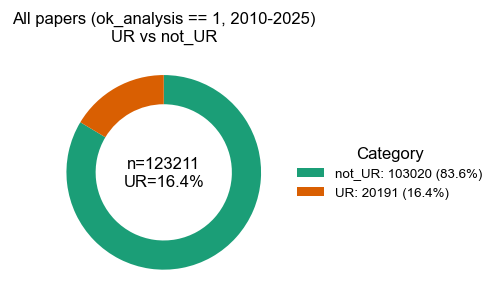

In [373]:
# donut
labels = summary_global["category"].values  # ["not_UR", "UR"]
values = summary_global["n"].values
pct_values = summary_global["pct"].values

total_ok = int(values.sum())
pct_ur1 = float(pct_values[labels.tolist().index("UR")]) if "UR" in labels else 0.0

fig, ax = plt.subplots(figsize=(4, 4))

wedges, _ = ax.pie(
    values,
    labels=None,
    colors=["C0", "C1"],
    startangle=90,
    counterclock=False,
    wedgeprops=dict(width=0.3),
)

# Center text: total and UR share
ax.text(
    0,
    0,
    f"n={total_ok}\nUR={pct_ur1:.1f}%",
    ha="center",
    va="center",
    fontsize=10,
)

# Legend with correct category names
legend_labels = [
    f"{lab}: {val} ({pct:.1f}%)"
    for lab, val, pct in zip(labels, values, pct_values)
]

ax.legend(
    wedges,
    legend_labels,
    loc="center left",
    bbox_to_anchor=(1.0, 0.5),
    frameon=False,
    title="Category",
)

title_years = f"{YEAR_MIN}-{YEAR_MAX}"
ax.set_title(f"All papers (ok_analysis == 1, {title_years})\nUR vs not_UR")
plt.tight_layout()

fig.savefig(out_dir_donut / "under_request_global_donut.png", dpi=300)
fig.savefig(out_dir_donut / "under_request_global_donut.pdf")
plt.close(fig)


fig

Across all ok_analysis == 1 articles (n = 123 211), 20 191 papers (16.4 %) contain at least one “under request” statement, while 83.6 % do not.

### Piechart plot : all papers UR 2010-2015

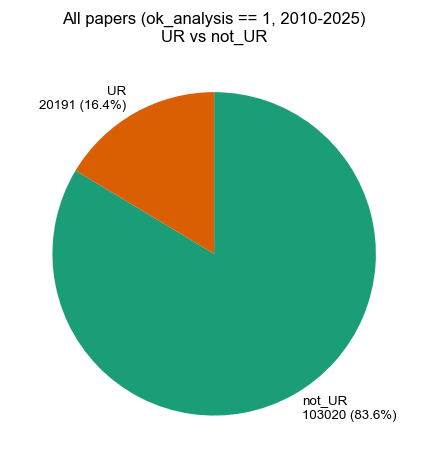

In [374]:
# piechart

labels = summary_global["category"].values  # ["not_UR", "UR"]
values = summary_global["n"].values
pct_values = summary_global["pct"].values

fig, ax = plt.subplots(figsize=(4, 4))

# Slice labels printed directly on the wedges
wedge_labels = [
    f"{lab}\n{val} ({pct:.1f}%)"
    for lab, val, pct in zip(labels, values, pct_values)
]

ax.pie(
    values,
    labels=wedge_labels,
    colors=["C0", "C1"],
    startangle=90,
    counterclock=False,
)

title_years = f"{YEAR_MIN}-{YEAR_MAX}"
ax.set_title(f"All papers (ok_analysis == 1, {title_years})\nUR vs not_UR")
plt.tight_layout()

fig.savefig(out_dir_donut / "under_request_global_pie.png", dpi=300)
fig.savefig(out_dir_donut / "under_request_global_pie.pdf")
plt.close(fig)

fig

Across all ok_analysis == 1 articles (n = 123 211), 20 191 papers (16.4 %) contain at least one “under request” statement, while 83.6 % do not.

### Barplot : all papers UR 2010-2015

For all articles with `ok_analysis == 1`, we summarise the nb of “under request” (UR) statements by comparing:

- papers **without** any “under request” wording (`not_UR`),
- and papers **with** at least one UR statement (`UR`).

From the `summary_global` table we derive, for each category:

- the absolute number of papers (`n`),
- the percentage of all analysable papers (`pct`).

We visualise these quantities as:

1. a barplot of **counts** (n) for `not_UR` and `UR`,
2. a barplot of **percentages** (% of all papers),
3. a **single 100% stacked bar**, where the two segments represent the share of `not_UR` and `UR` papers, each annotated with `n` and `%`.

All three plots are exported to `4.analyses/upon_request/under_request_donut_pie_bar/` alongside the underlying TSV.


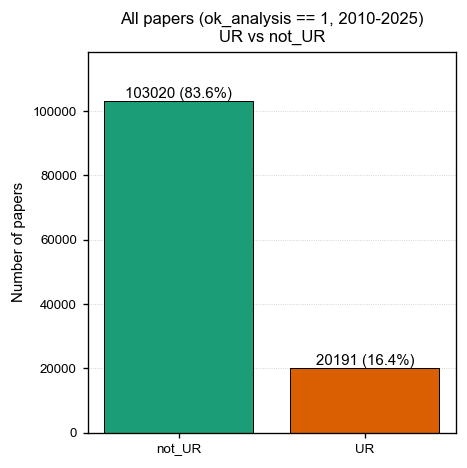

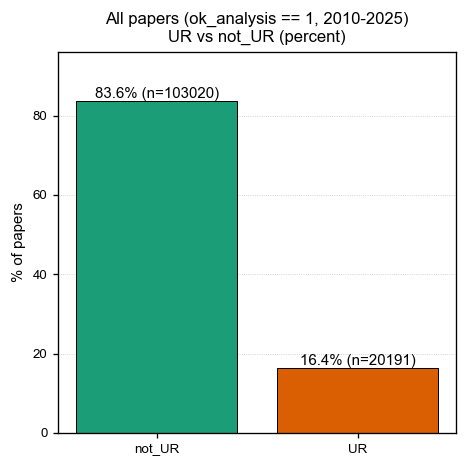

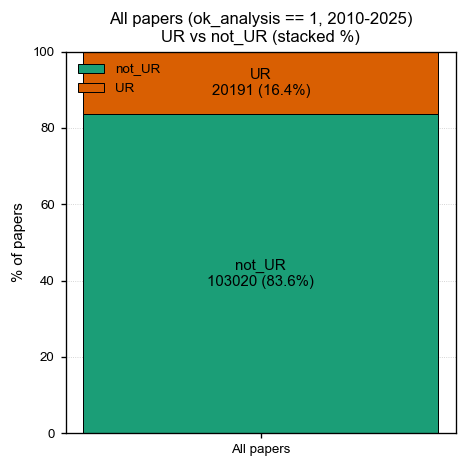

In [399]:
# Bar / stacked plots for global UR vs not_UR

labels = summary_global["category"].values   # e.g. ["not_UR", "UR"]
values = summary_global["n"].values
pct_values = summary_global["pct"].values

x = np.arange(len(labels))

# Try to reuse consistent colors if defined, else fallback
try:
    colors = [COLOR_NOT_UR, COLOR_UR]
except NameError:
    colors = ["C0", "C1"]

title_years = f"{YEAR_MIN}-{YEAR_MAX}"

# ------------------------------------------------------------------
# 1) Barplot in counts (n)
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(4, 4))

bars = ax.bar(x, values, color=colors, edgecolor="black", linewidth=0.6)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Number of papers")
ax.set_title(f"All papers (ok_analysis == 1, {title_years})\nUR vs not_UR")
ax.set_ylim(0, max(values) * 1.15)

# Annotate bars with n and %
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{values[i]} ({pct_values[i]:.1f}%)",
        ha="center",
        va="bottom",
        fontsize=9,
    )

ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.7)
ax.set_axisbelow(True)

plt.tight_layout()
fig.savefig(out_dir_donut / "under_request_global_bar.png", dpi=300)
fig.savefig(out_dir_donut / "under_request_global_bar.pdf")

display(fig)

plt.close(fig)

# ------------------------------------------------------------------
# 2) Barplot in percentages (% of all papers)
# ------------------------------------------------------------------
fig_pct, ax_pct = plt.subplots(figsize=(4, 4))

bars_pct = ax_pct.bar(x, pct_values, color=colors, edgecolor="black", linewidth=0.6)

ax_pct.set_xticks(x)
ax_pct.set_xticklabels(labels)
ax_pct.set_ylabel("% of papers")
ax_pct.set_title(f"All papers (ok_analysis == 1, {title_years})\nUR vs not_UR (percent)")
ax_pct.set_ylim(0, max(pct_values) * 1.15)

# Annotate bars with % and n
for i, bar in enumerate(bars_pct):
    height = bar.get_height()
    ax_pct.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{pct_values[i]:.1f}% (n={values[i]})",
        ha="center",
        va="bottom",
        fontsize=9,
    )

ax_pct.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.7)
ax_pct.set_axisbelow(True)

plt.tight_layout()
fig_pct.savefig(out_dir_donut / "under_request_global_bar_pct.png", dpi=300)
fig_pct.savefig(out_dir_donut / "under_request_global_bar_pct.pdf")

display(fig_pct)

plt.close(fig_pct)

# ------------------------------------------------------------------
# 3) Single stacked bar in percentages (%)
# ------------------------------------------------------------------
fig_stack, ax_stack = plt.subplots(figsize=(4, 4))

# One bar at x=0, stacked not_UR (bottom) + UR (top)
x_stack = [0]
bottom = 0.0

for i, label in enumerate(labels):
    h = pct_values[i]
    ax_stack.bar(
        x_stack,
        h,
        bottom=bottom,
        color=colors[i],
        edgecolor="black",
        linewidth=0.6,
        label=label,
    )
    # Annotate inside segment if reasonably large
    if h > 3.0:
        ax_stack.text(
            x_stack[0],
            bottom + h / 2,
            f"{label}\n{values[i]} ({h:.1f}%)",
            ha="center",
            va="center",
            fontsize=9,
        )
    bottom += h

ax_stack.set_xticks(x_stack)
ax_stack.set_xticklabels(["All papers"])
ax_stack.set_ylabel("% of papers")
ax_stack.set_ylim(0, 100)
ax_stack.set_title(f"All papers (ok_analysis == 1, {title_years})\nUR vs not_UR (stacked %)")

ax_stack.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.7)
ax_stack.set_axisbelow(True)

ax_stack.legend(loc="upper left", frameon=False)

plt.tight_layout()
fig_stack.savefig(out_dir_donut / "under_request_global_stacked_pct.png", dpi=300)
fig_stack.savefig(out_dir_donut / "under_request_global_stacked_pct.pdf")

display(fig_stack)

plt.close(fig_stack)



Across all ok_analysis == 1 articles (n = 123 211), 20 191 papers (16.4 %) contain at least one “under request” statement, while 83.6 % do not.

Trying different barplot layout for the figure panel (yaxis in the middle)

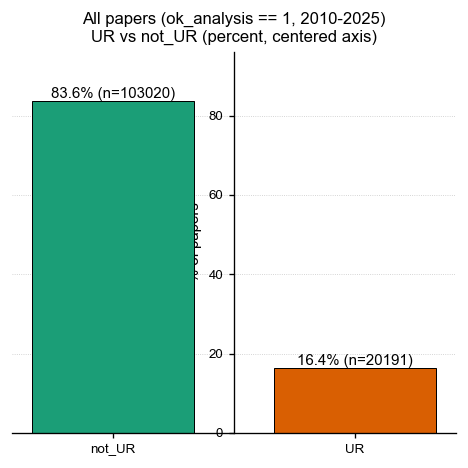

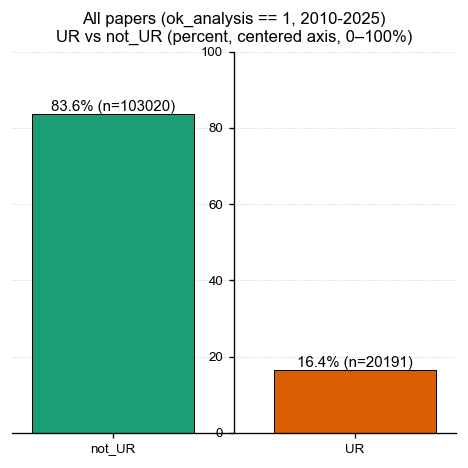

In [401]:
# Barplot in percent with y-axis between the two bars

x_pos = np.array([-0.6, 0.6])  # left and right of the central axis

title_years = f"{YEAR_MIN}-{YEAR_MAX}"

# ------------------------------------------------------------------
# 1) Centered percent barplot (auto y-limit)
# ------------------------------------------------------------------
fig_pct2, ax_pct2 = plt.subplots(figsize=(4, 4))

bars_pct2 = ax_pct2.bar(
    x_pos,
    pct_values,
    width=0.8,
    color=colors,
    edgecolor="black",
    linewidth=0.6,
)

ax_pct2.set_xticks(x_pos)
ax_pct2.set_xticklabels(labels)
ax_pct2.set_ylabel("% of papers")
ax_pct2.set_title(
    f"All papers (ok_analysis == 1, {title_years})\nUR vs not_UR (percent, centered axis)"
)
ax_pct2.set_ylim(0, max(pct_values) * 1.15)

# Put the y-axis spine in the middle, between the two bars
ax_pct2.spines["left"].set_position("center")
ax_pct2.spines["right"].set_visible(False)
ax_pct2.spines["top"].set_visible(False)
ax_pct2.yaxis.set_ticks_position("left")
ax_pct2.xaxis.set_ticks_position("bottom")

# Annotate bars with % and n
for i, bar in enumerate(bars_pct2):
    height = bar.get_height()
    ax_pct2.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{pct_values[i]:.1f}% (n={values[i]})",
        ha="center",
        va="bottom",
        fontsize=9,
    )

ax_pct2.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.7)
ax_pct2.set_axisbelow(True)

fig_pct2.tight_layout()

png2 = out_dir_donut / "under_request_global_bar_pct_centered.png"
pdf2 = out_dir_donut / "under_request_global_bar_pct_centered.pdf"
fig_pct2.savefig(png2, dpi=300)
fig_pct2.savefig(pdf2)

display(fig_pct2)
plt.close(fig_pct2)

# ------------------------------------------------------------------
# 2) Centered percent barplot with y-axis fixed to [0, 100]
# ------------------------------------------------------------------
fig_pct3, ax_pct3 = plt.subplots(figsize=(4, 4))

bars_pct3 = ax_pct3.bar(
    x_pos,
    pct_values,
    width=0.8,
    color=colors,
    edgecolor="black",
    linewidth=0.6,
)

ax_pct3.set_xticks(x_pos)
ax_pct3.set_xticklabels(labels)
ax_pct3.set_ylabel("% of papers")
ax_pct3.set_title(
    f"All papers (ok_analysis == 1, {title_years})\nUR vs not_UR (percent, centered axis, 0–100%)"
)
ax_pct3.set_ylim(0, 100)

# Center y-axis spine again
ax_pct3.spines["left"].set_position("center")
ax_pct3.spines["right"].set_visible(False)
ax_pct3.spines["top"].set_visible(False)
ax_pct3.yaxis.set_ticks_position("left")
ax_pct3.xaxis.set_ticks_position("bottom")

# Annotate bars with % and n
for i, bar in enumerate(bars_pct3):
    height = bar.get_height()
    ax_pct3.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{pct_values[i]:.1f}% (n={values[i]})",
        ha="center",
        va="bottom",
        fontsize=9,
    )

ax_pct3.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.7)
ax_pct3.set_axisbelow(True)

fig_pct3.tight_layout()

png3 = out_dir_donut / "under_request_global_bar_pct_centered_100.png"
pdf3 = out_dir_donut / "under_request_global_bar_pct_centered_100.pdf"
fig_pct3.savefig(png3, dpi=300)
fig_pct3.savefig(pdf3)

display(fig_pct3)
plt.close(fig_pct3)


### 1.2 Global breakdown of UR articles by “genuine” status

We next refine the global counts of “under request” (UR) statements using the `genuine` flag from `08_tag_under_request_compliance.py`. Among all papers with `ok_analysis == 1` we distinguish three mutually exclusive categories:

1. **not_UR**: `under_request == 0` (no UR wording in the article),
2. **UR & genuine == 1**: `under_request == 1` and `genuine == 1`  
   (UR statement judged to be a genuine data- or material-sharing route),
3. **UR & genuine == 0**: `under_request == 1` and `genuine == 0`  
   (UR wording present but judged non-genuine, for example vague, non-data, or otherwise not a meaningful access route).

For each category we compute its share of all analysable papers (`ok_analysis == 1`) and visualise the result as:

- a pie chart,
- a single 100 % stacked bar,
- and a barplot where the first bar represents `not_UR`, and the second bar represents all UR articles, internally stacked into `UR & genuine == 1` and `UR & genuine == 0`.

All percentages are computed relative to the full set of `ok_analysis == 1` papers in the analysis window.


Total papers with ok_analysis == 1 in window 2010-2025: 123211


,category,n,pct
0,not_UR,103020,83.612664
1,UR & genuine==1,1973,1.601318
2,UR & genuine==0,18218,14.786017


Wrote /Users/benoit/work/under_request/4.analyses/upon_request/under_request_donut_pie_bar/under_request_genuine_global_counts.tsv


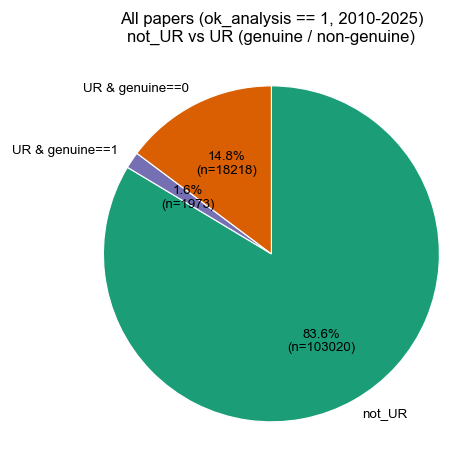

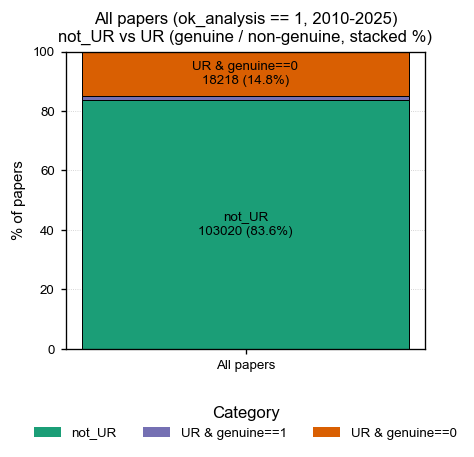

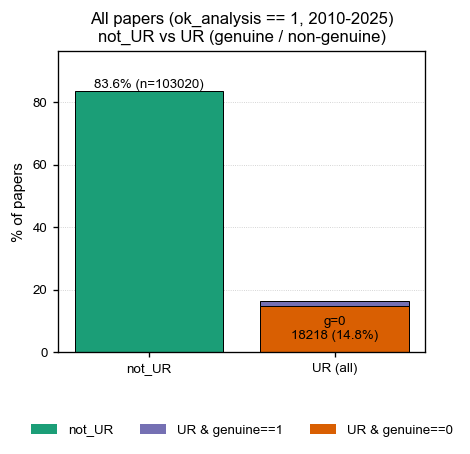

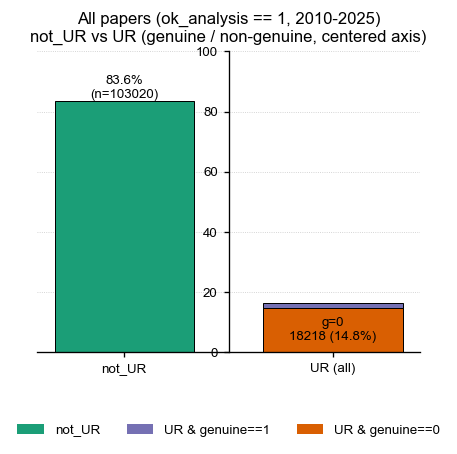

In [409]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display

# ------------------------------------------------------------------
# Compute global counts for: not_UR, UR & genuine==1, UR & genuine==0
# ------------------------------------------------------------------

df_g = df.copy()

# Ensure numeric flags
df_g["ok_analysis_num"] = (
    pd.to_numeric(df_g.get("ok_analysis", 0), errors="coerce").fillna(0).astype(int)
)
df_g["under_request_num"] = (
    pd.to_numeric(df_g.get("under_request", 0), errors="coerce").fillna(0).astype(int)
)
df_g["genuine_num"] = (
    pd.to_numeric(df_g.get("genuine", 0), errors="coerce").fillna(0).astype(int)
)

# Year restriction (if a year column is present)
year_col = "year" if "year" in df_g.columns else ("pub_year" if "pub_year" in df_g.columns else None)

mask_ok = df_g["ok_analysis_num"] == 1
if year_col is not None:
    df_g[year_col] = pd.to_numeric(df_g[year_col], errors="coerce")
    mask_year = df_g[year_col].between(YEAR_MIN, YEAR_MAX)
    df_ok = df_g[mask_ok & mask_year].copy()
else:
    df_ok = df_g[mask_ok].copy()

total_ok = len(df_ok)
print(f"Total papers with ok_analysis == 1 in window {YEAR_MIN}-{YEAR_MAX}: {total_ok}")

n_not_ur = (df_ok["under_request_num"] == 0).sum()
n_ur_g1 = ((df_ok["under_request_num"] == 1) & (df_ok["genuine_num"] == 1)).sum()
n_ur_g0 = ((df_ok["under_request_num"] == 1) & (df_ok["genuine_num"] == 0)).sum()

summary_g = pd.DataFrame(
    {
        "category": [
            "not_UR",
            "UR & genuine==1",
            "UR & genuine==0",
        ],
        "n": [n_not_ur, n_ur_g1, n_ur_g0],
    }
)
summary_g["pct"] = summary_g["n"] / total_ok * 100.0

display(summary_g)

# Save TSV
out_dir_genuine = out_dir_donut  # reuse same directory
tsv_g = out_dir_genuine / "under_request_genuine_global_counts.tsv"
summary_g.to_csv(tsv_g, sep="\t", index=False)
print(f"Wrote {tsv_g}")

labels = summary_g["category"].values
values = summary_g["n"].values
pct_values = summary_g["pct"].values

# Colors (try to reuse global ones if available)
try:
    color_not_ur = COLOR_NOT_UR
except NameError:
    color_not_ur = "#1b9e77"  # green

color_ur_g1 = "#7570b3"  # purple/blue
color_ur_g0 = "#d95f02"  # orange

colors3 = [color_not_ur, color_ur_g1, color_ur_g0]

title_years = f"{YEAR_MIN}-{YEAR_MAX}"

# ------------------------------------------------------------------
# 1) Pie chart (in %, with n)
# ------------------------------------------------------------------

def make_autopct(vals):
    total = np.sum(vals)

    def _autopct(pct):
        n = int(round(pct * total / 100.0))
        return f"{pct:.1f}%\n(n={n})"

    return _autopct

fig_pie, ax_pie = plt.subplots(figsize=(4, 4))
wedges, texts, autotexts = ax_pie.pie(
    values,
    labels=labels,
    colors=colors3,
    autopct=make_autopct(values),
    startangle=90,
    counterclock=False,
    wedgeprops={"linewidth": 0.7, "edgecolor": "white"},
)
ax_pie.set_title(
    f"All papers (ok_analysis == 1, {title_years})\nnot_UR vs UR (genuine / non-genuine)"
)
ax_pie.axis("equal")

for t in autotexts:
    t.set_fontsize(8)

fig_pie.tight_layout()
fig_pie.savefig(out_dir_genuine / "under_request_genuine_global_pie.png", dpi=300)
fig_pie.savefig(out_dir_genuine / "under_request_genuine_global_pie.pdf")

display(fig_pie)
plt.close(fig_pie)

# ------------------------------------------------------------------
# 2) Single stacked bar in % (3 segments)
# ------------------------------------------------------------------

fig_stack, ax_stack = plt.subplots(figsize=(4, 4))

x_stack = [0]
bottom = 0.0

for i, lab in enumerate(labels):
    h = pct_values[i]
    ax_stack.bar(
        x_stack,
        h,
        bottom=bottom,
        color=colors3[i],
        edgecolor="black",
        linewidth=0.6,
        label=lab,
    )
    if h > 2.0:
        ax_stack.text(
            x_stack[0],
            bottom + h / 2,
            f"{lab}\n{values[i]} ({h:.1f}%)",
            ha="center",
            va="center",
            fontsize=8,
        )
    bottom += h

ax_stack.set_xticks(x_stack)
ax_stack.set_xticklabels(["All papers"])
ax_stack.set_ylabel("% of papers")
ax_stack.set_ylim(0, 100)
ax_stack.set_title(
    f"All papers (ok_analysis == 1, {title_years})\nnot_UR vs UR (genuine / non-genuine, stacked %)"
)

ax_stack.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.7)
ax_stack.set_axisbelow(True)

handles = [
    mpl.patches.Patch(facecolor=colors3[i], label=labels[i]) for i in range(len(labels))
]
ax_stack.legend(
    handles,
    [h.get_label() for h in handles],
    title="Category",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    frameon=False,
)

fig_stack.tight_layout()
fig_stack.savefig(out_dir_genuine / "under_request_genuine_global_stacked_pct.png", dpi=300)
fig_stack.savefig(out_dir_genuine / "under_request_genuine_global_stacked_pct.pdf")

display(fig_stack)
plt.close(fig_stack)

# ------------------------------------------------------------------
# 3) Barplot: not_UR vs UR (stacked into genuine/non-genuine)
# ------------------------------------------------------------------

# Heights in % relative to all ok_analysis==1 papers
pct_not_ur = pct_values[0]
pct_ur_g1 = pct_values[1]
pct_ur_g0 = pct_values[2]

x_bar = np.array([0, 1])  # 0 = not_UR, 1 = UR (stacked)
fig_bar, ax_bar = plt.subplots(figsize=(4, 4))

# Bar for not_UR (single segment)
bar0 = ax_bar.bar(
    [x_bar[0]],
    [pct_not_ur],
    color=color_not_ur,
    edgecolor="black",
    linewidth=0.6,
    label="not_UR",
)

# Bar for all UR: stacked g=0 at bottom, g=1 on top
bottom = 0.0
bar1_g0 = ax_bar.bar(
    [x_bar[1]],
    [pct_ur_g0],
    bottom=bottom,
    color=color_ur_g0,
    edgecolor="black",
    linewidth=0.6,
    label="UR & genuine==0",
)
bottom += pct_ur_g0
bar1_g1 = ax_bar.bar(
    [x_bar[1]],
    [pct_ur_g1],
    bottom=bottom,
    color=color_ur_g1,
    edgecolor="black",
    linewidth=0.6,
    label="UR & genuine==1",
)

ax_bar.set_xticks(x_bar)
ax_bar.set_xticklabels(["not_UR", "UR (all)"])
ax_bar.set_ylabel("% of papers")
ax_bar.set_ylim(0, max(pct_not_ur, pct_ur_g0 + pct_ur_g1) * 1.15)
ax_bar.set_title(
    f"All papers (ok_analysis == 1, {title_years})\nnot_UR vs UR (genuine / non-genuine)"
)

# Annotate not_UR bar
ax_bar.text(
    x_bar[0],
    pct_not_ur,
    f"{pct_not_ur:.1f}% (n={n_not_ur})",
    ha="center",
    va="bottom",
    fontsize=8,
)

# Annotate UR stacked bar
if pct_ur_g0 > 2.0:
    ax_bar.text(
        x_bar[1],
        pct_ur_g0 / 2.0,
        f"g=0\n{n_ur_g0} ({pct_ur_g0:.1f}%)",
        ha="center",
        va="center",
        fontsize=8,
    )
if pct_ur_g1 > 2.0:
    ax_bar.text(
        x_bar[1],
        pct_ur_g0 + pct_ur_g1 / 2.0,
        f"g=1\n{n_ur_g1} ({pct_ur_g1:.1f}%)",
        ha="center",
        va="center",
        fontsize=8,
    )

ax_bar.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.7)
ax_bar.set_axisbelow(True)

# Legend (3 categories)
handles_bar = [
    mpl.patches.Patch(facecolor=color_not_ur, label="not_UR"),
    mpl.patches.Patch(facecolor=color_ur_g1, label="UR & genuine==1"),
    mpl.patches.Patch(facecolor=color_ur_g0, label="UR & genuine==0"),
]
ax_bar.legend(
    handles_bar,
    [h.get_label() for h in handles_bar],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.20),
    ncol=3,
    frameon=False,
)

fig_bar.tight_layout()
fig_bar.savefig(out_dir_genuine / "under_request_genuine_global_bar_pct.png", dpi=300)
fig_bar.savefig(out_dir_genuine / "under_request_genuine_global_bar_pct.pdf")

display(fig_bar)
plt.close(fig_bar)


# ------------------------------------------------------------------
# 3) Centered barplot: not_UR vs UR (UR stacked into genuine / non-genuine)
# ------------------------------------------------------------------

# Heights in % relative to all ok_analysis==1 papers
pct_not_ur = pct_values[0]
pct_ur_g1 = pct_values[1]
pct_ur_g0 = pct_values[2]

# Positions: one bar left, one bar right of centered y-axis
x_bar = np.array([-0.6, 0.6])  # x_bar[0] = not_UR, x_bar[1] = UR (stacked)

fig_bar_c, ax_bar_c = plt.subplots(figsize=(4, 4))

# Bar for not_UR (single segment)
ax_bar_c.bar(
    [x_bar[0]],
    [pct_not_ur],
    color=color_not_ur,
    edgecolor="black",
    linewidth=0.6,
    label="not_UR",
)

# Bar for all UR: stacked g=0 at bottom, g=1 on top
bottom = 0.0
ax_bar_c.bar(
    [x_bar[1]],
    [pct_ur_g0],
    bottom=bottom,
    color=color_ur_g0,
    edgecolor="black",
    linewidth=0.6,
    label="UR & genuine==0",
)
bottom += pct_ur_g0
ax_bar_c.bar(
    [x_bar[1]],
    [pct_ur_g1],
    bottom=bottom,
    color=color_ur_g1,
    edgecolor="black",
    linewidth=0.6,
    label="UR & genuine==1",
)

ax_bar_c.set_xticks(x_bar)
ax_bar_c.set_xticklabels(["not_UR", "UR (all)"])
ax_bar_c.set_ylabel("% of papers")
ax_bar_c.set_ylim(0, 100)  # full 0–100% scale
ax_bar_c.set_title(
    f"All papers (ok_analysis == 1, {title_years})\n"
    "not_UR vs UR (genuine / non-genuine, centered axis)"
)

# Center the y-axis spine between the two bars
ax_bar_c.spines["left"].set_position("center")
ax_bar_c.spines["right"].set_visible(False)
ax_bar_c.spines["top"].set_visible(False)
ax_bar_c.yaxis.set_ticks_position("left")
ax_bar_c.xaxis.set_ticks_position("bottom")

# Annotate not_UR bar
ax_bar_c.text(
    x_bar[0],
    pct_not_ur,
    f"{pct_not_ur:.1f}%\n(n={n_not_ur})",
    ha="center",
    va="bottom",
    fontsize=8,
)

# Annotate UR stacked bar
if pct_ur_g0 > 2.0:
    ax_bar_c.text(
        x_bar[1],
        pct_ur_g0 / 2.0,
        f"g=0\n{n_ur_g0} ({pct_ur_g0:.1f}%)",
        ha="center",
        va="center",
        fontsize=8,
    )
if pct_ur_g1 > 2.0:
    ax_bar_c.text(
        x_bar[1],
        pct_ur_g0 + pct_ur_g1 / 2.0,
        f"g=1\n{n_ur_g1} ({pct_ur_g1:.1f}%)",
        ha="center",
        va="center",
        fontsize=8,
    )

ax_bar_c.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.7)
ax_bar_c.set_axisbelow(True)

# Legend (3 categories)
handles_bar_c = [
    mpl.patches.Patch(facecolor=color_not_ur, label="not_UR"),
    mpl.patches.Patch(facecolor=color_ur_g1, label="UR & genuine==1"),
    mpl.patches.Patch(facecolor=color_ur_g0, label="UR & genuine==0"),
]
ax_bar_c.legend(
    handles_bar_c,
    [h.get_label() for h in handles_bar_c],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.20),
    ncol=3,
    frameon=False,
)

fig_bar_c.tight_layout()
fig_bar_c.savefig(
    out_dir_genuine / "under_request_genuine_global_bar_pct_centered.png",
    dpi=300,
)
fig_bar_c.savefig(
    out_dir_genuine / "under_request_genuine_global_bar_pct_centered.pdf"
)

display(fig_bar_c)
plt.close(fig_bar_c)





## 2. Time trends in "under request" statements

To examine how "upon request" statements have evolved over time, we collapse the data by publication year and calculate, for each year:

- the total number of analysable articles (`ok_analysis == 1`),
- the number with `under_request == 1`,
- and the corresponding percentage of "under request" articles.

We then produce:

- line plots of the absolute number of "under request" articles per year,
- stacked barplots showing the proportion of articles with and without "under request" statements by year.

These figures allow us to see whether "upon request" language was more prevalent in earlier years and how it changes around key policy milestones, for example journal data policies or the introduction of stronger open data requirements.


### Plotting the under request by years

In [392]:
# Cell 2 – Load data and policy timeline
# Load main table
df = pd.read_csv(input_path, sep="\t", dtype=str, keep_default_na=False)

if "year" not in df.columns:
    raise ValueError("Expected a 'year' column in meta_under_request_tagged.tsv")

df["year"] = pd.to_numeric(df["year"], errors="coerce")

# ok_analysis column may have different names
ok_col = "ok_analysis" if "ok_analysis" in df.columns else (
    "analysis_ok" if "analysis_ok" in df.columns else None
)

if ok_col is None:
    df["ok_analysis_num"] = 0
else:
    df["ok_analysis_num"] = (
        pd.to_numeric(df[ok_col], errors="coerce")
        .fillna(0)
        .astype(int)
    )

# under_request flag
if "under_request" in df.columns:
    df["under_request_num"] = (
        pd.to_numeric(df["under_request"], errors="coerce")
        .fillna(0)
        .astype(int)
    )
else:
    df["under_request_num"] = 0

# Restrict to valid years in our window
df = df.dropna(subset=["year"]).copy()
df["year"] = df["year"].astype(int)
df = df[(df["year"] >= YEAR_MIN) & (df["year"] <= YEAR_MAX)].copy()

df.head()


,pmid,pmcid,OA,OA_subset,journal,pub_date,year,PublicationType,ok_analysis,DOI,...,matching,phrase,section,restricted_initial_parse,domain,reason,genuine,restricted,ok_analysis_num,under_request_num
0,19966787,2999963,1,1,Nature,14/01/2010,2010,Journal Article,1,10.1038/nature08678,...,,,,0,none,none,,0,1,0
1,20016488,2880489,1,1,Nature,14/01/2010,2010,Journal Article,1,10.1038/nature08629,...,,,,0,none,none,,0,1,0
2,20023628,2811870,1,1,Nature,07/01/2010,2010,Journal Article,1,10.1038/nature08648,...,,,,0,none,none,,0,1,0
3,20032975,4011561,1,1,Nature,21/01/2010,2010,Journal Article,1,10.1038/nature08712,...,,,,0,none,none,,0,1,0
4,20054295,2894702,1,1,Nature,04/02/2010,2010,Journal Article,1,10.1038/nature08725,...,,,,0,none,none,,0,1,0


In [377]:
# Optionally load the policy timeline and a helper to overlay vertical lines:
# Load policy timeline if present
if timeline_path.exists():
    timeline = pd.read_csv(timeline_path, sep="\t", dtype=str, keep_default_na=False)
    timeline["year"] = pd.to_numeric(timeline["year"], errors="coerce")
    timeline = timeline.dropna(subset=["year"])
else:
    timeline = None

def overlay_policy_lines(ax, timeline_df):
    """Draw vertical policy lines given a timeline table with a 'year' column."""
    if timeline_df is None or timeline_df.empty:
        return
    ymin, ymax = ax.get_ylim()
    for _, row in timeline_df.iterrows():
        yr = row["year"]
        ax.axvline(yr, color="gray", linestyle="--", linewidth=1, alpha=0.6)
        ax.text(
            yr + 0.05,
            ymax * 0.98,
            str(int(yr)),
            rotation=90,
            va="top",
            ha="left",
            fontsize=8,
            color="gray",
        )

timeline.head() if timeline is not None else "No policy timeline loaded"


,year,publisher,journal_scope,policy,notes,url
0,2014,PLOS,All PLOS journals,Data Availability Statements required,Portfolio-wide policy starting March 2014; dat...,https://journals.plos.org/plosone/s/data-avail...
1,2016,Cell Press,Cell + life-science titles,STAR Methods introduced,"Structured, Transparent, Accessible Reporting;...",https://www.cell.com/star-methods
2,2016,Nature Portfolio,Nature (flagship) + initial pilot journals,Mandatory Data Availability Statements (pilot/...,DAS piloted at 5 journals (Mar 2016) and adopt...,
3,2017,Nature Portfolio,Nature Research journals,Mandatory Data Availability Statements (rollout),Rollout across the portfolio after 2016 pilot/...,
4,2010,AAAS,Science (policy long-standing),Data & materials availability required,Policy predates 2016–2017; specify article-typ...,https://www.science.org/content/page/science-j...


## 3. Differences between journals

Next, we quantify how the use of "data available upon request" varies between journals. For each journal in the corpus, we compute:

- the number of analysable articles (`ok_analysis == 1`),
- the number with `under_request == 1`,
- and the percentage of "under request" articles.

We display these results as:

- a barplot of the percentage of "under request" articles per journal,  
- and corresponding barplots in absolute counts.

Journals are sorted by the percentage of "under request" articles to facilitate comparisons. These plots highlight journals that have historically relied heavily on "upon request" formulations versus those where such statements are rare.


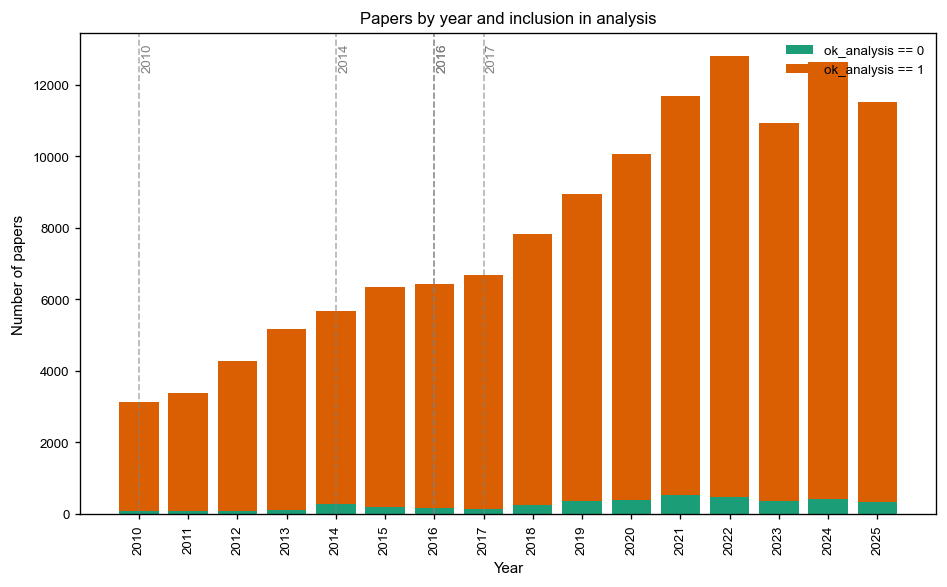

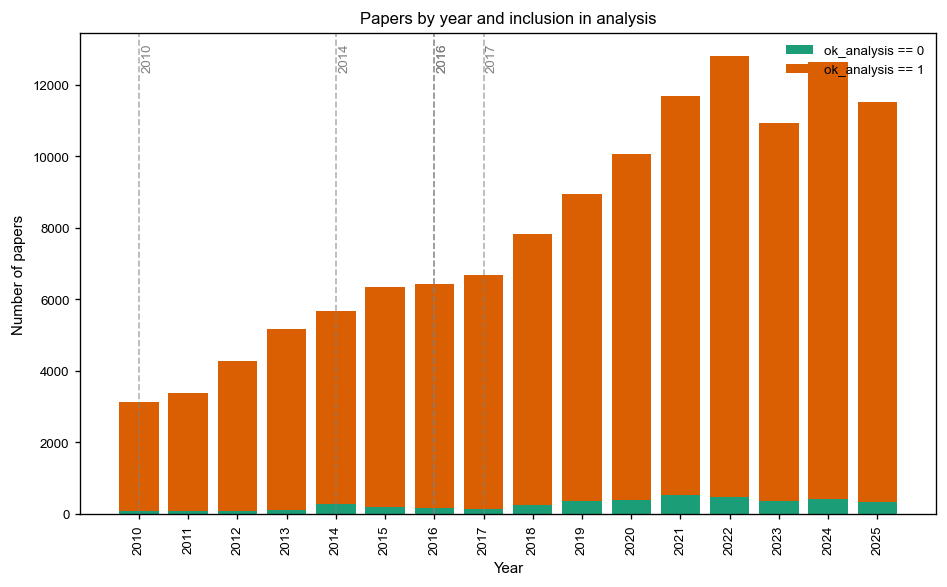

In [378]:
# Cell 3 – P1: Papers by year (total vs used in analysis)
# This reproduces the “papers by year” plot and writes a TSV + PNG + PDF in 4.analyses/papers_by_year/.

years = pd.Series(range(YEAR_MIN, YEAR_MAX + 1), name="year")

# total per year
total = df.groupby("year").size().rename("n_total")

# ok_analysis == 1 per year
ok1 = df[df["ok_analysis_num"] == 1].groupby("year").size().rename("n_ok")

summary_p1 = (
    pd.DataFrame({"year": years})
    .merge(total.reset_index(), on="year", how="left")
    .merge(ok1.reset_index(), on="year", how="left")
)

summary_p1["n_total"] = summary_p1["n_total"].fillna(0).astype(int)
summary_p1["n_ok"] = summary_p1["n_ok"].fillna(0).astype(int)
summary_p1["n_not_ok"] = (summary_p1["n_total"] - summary_p1["n_ok"]).clip(lower=0).astype(int)

# Save TSV
summary_p1.to_csv(out_papers / "papers_by_year.tsv", sep="\t", index=False)

summary_p1.head()

# Plot (stacked):

fig, ax = plt.subplots(figsize=(8, 5))

x = summary_p1["year"]
base = summary_p1["n_not_ok"]
top = summary_p1["n_ok"]

ax.bar(x, base, label="ok_analysis == 0")
ax.bar(x, top, bottom=base, label="ok_analysis == 1")

ax.set_xlabel("Year")
ax.set_ylabel("Number of papers")
ax.set_title("Papers by year and inclusion in analysis")
ax.set_xticks(x)
ax.set_xticklabels(x, rotation=90)

overlay_policy_lines(ax, timeline)

ax.legend(frameon=False)
plt.tight_layout()

fig.savefig(out_papers / "papers_by_year.png", dpi=300)
fig.savefig(out_papers / "papers_by_year.pdf")

fig

### Number of Upon Request papers per year
This plot the number of papers having an UR (or not) mention in the text. Also showing the different policy timelines. 

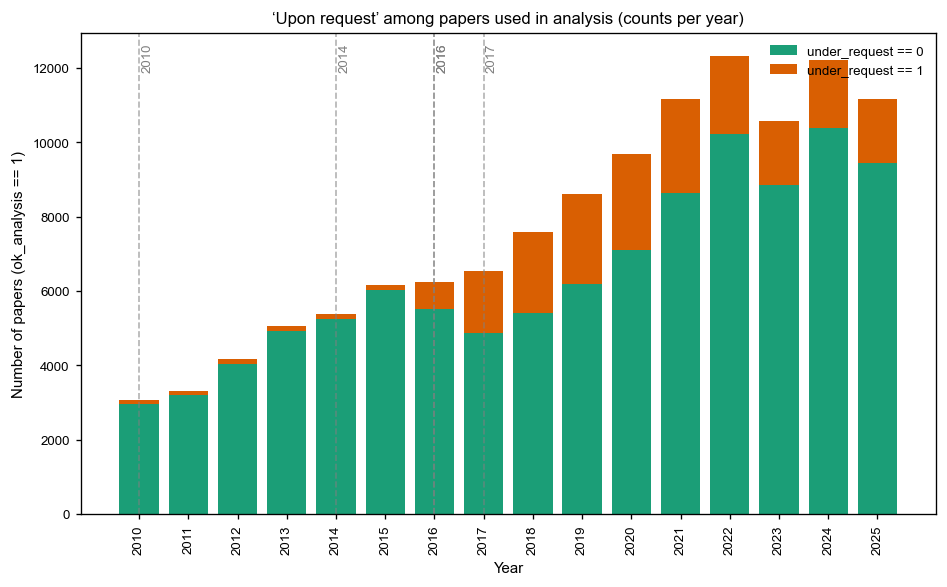

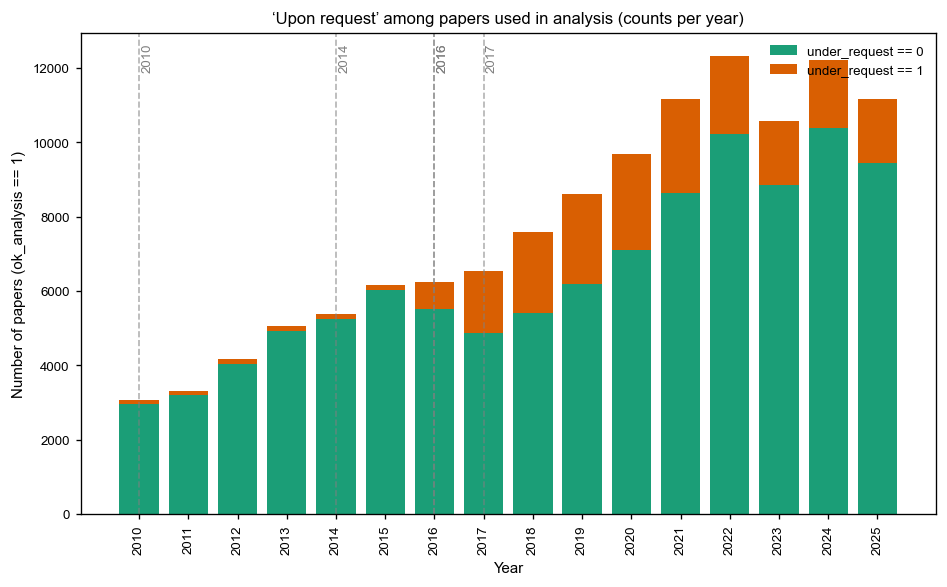

In [379]:
# Cell 4 – P2: Among ok_analysis == 1, under_request counts per year
# Outputs TSV + PNG + PDF in 4.analyses/upon_request/under_request/.
df_ok = df[df["ok_analysis_num"] == 1].copy()

counts = (
    df_ok.groupby(["year", "under_request_num"])
         .size()
         .reset_index(name="n")
)

# Pivot to get columns not_ur and ur
pivot_counts = (
    counts
    .pivot(index="year", columns="under_request_num", values="n")
    .fillna(0)
    .rename(columns={0: "not_ur", 1: "ur"})
    .reset_index()
)

# Ensure all years in range are present
years_df = pd.DataFrame({"year": range(YEAR_MIN, YEAR_MAX + 1)})
pivot_counts = years_df.merge(pivot_counts, on="year", how="left")
pivot_counts[["not_ur", "ur"]] = pivot_counts[["not_ur", "ur"]].fillna(0).astype(int)

pivot_counts.to_csv(
    out_upon / "under_request" / "under_request.tsv",
    sep="\t",
    index=False,
)

pivot_counts.head()

# Plot

fig, ax = plt.subplots(figsize=(8, 5))

x = pivot_counts["year"]
base = pivot_counts["not_ur"]
top = pivot_counts["ur"]

ax.bar(x, base, label="under_request == 0")
ax.bar(x, top, bottom=base, label="under_request == 1")

ax.set_xlabel("Year")
ax.set_ylabel("Number of papers (ok_analysis == 1)")
ax.set_title("‘Upon request’ among papers used in analysis (counts per year)")
ax.set_xticks(x)
ax.set_xticklabels(x, rotation=90)

overlay_policy_lines(ax, timeline)

ax.legend(frameon=False)
plt.tight_layout()

fig.savefig(
    out_upon / "under_request" / "under_request.png",
    dpi=300,
)
fig.savefig(
    out_upon / "under_request" / "under_request.pdf",
)

fig


Journals differ markedly in their reliance on “upon request” language. For example, approximately 36 % of analysable Nature Communications articles contain a UR statement, versus less than 5 % in Genome Research

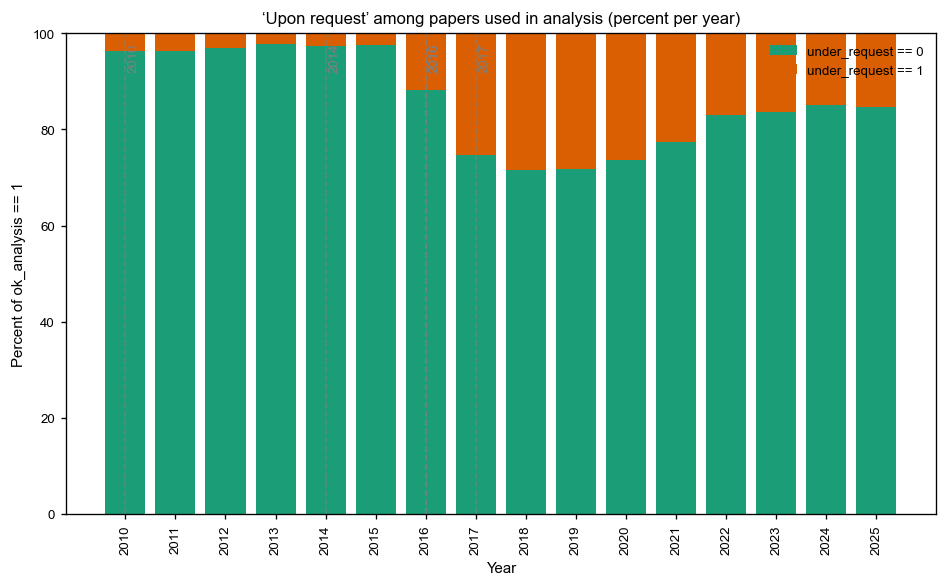

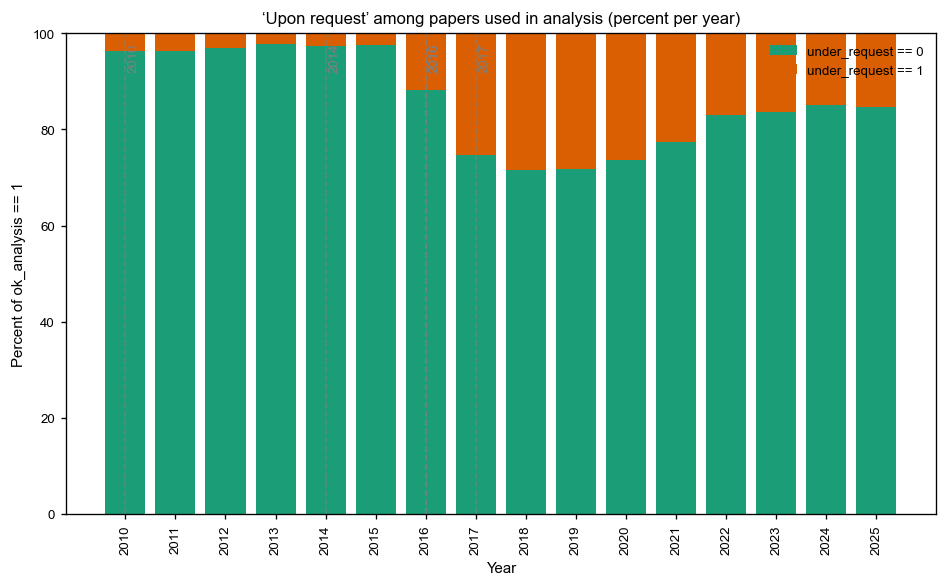

In [380]:
# Cell 5 – P3: Among ok_analysis == 1, under_request percent per year
# Outputs TSV + PNG + PDF in 4.analyses/upon_request/under_request_pct/.

summary_pct = pivot_counts.copy()
total = summary_pct["not_ur"] + summary_pct["ur"]
summary_pct["not_ur_pct"] = 100.0 * summary_pct["not_ur"] / total.replace(0, np.nan)
summary_pct["ur_pct"] = 100.0 * summary_pct["ur"] / total.replace(0, np.nan)

summary_pct.to_csv(
    out_upon / "under_request_pct" / "under_request_pct.tsv",
    sep="\t",
    index=False,
)

summary_pct.head()


# Plot

fig, ax = plt.subplots(figsize=(8, 5))

x = summary_pct["year"]
base = summary_pct["not_ur_pct"].fillna(0)
top = summary_pct["ur_pct"].fillna(0)

ax.bar(x, base, label="under_request == 0")
ax.bar(x, top, bottom=base, label="under_request == 1")

ax.set_xlabel("Year")
ax.set_ylabel("Percent of ok_analysis == 1")
ax.set_title("‘Upon request’ among papers used in analysis (percent per year)")
ax.set_xticks(x)
ax.set_xticklabels(x, rotation=90)
ax.set_ylim(0, 100)

overlay_policy_lines(ax, timeline)

ax.legend(frameon=False)
plt.tight_layout()

fig.savefig(
    out_upon / "under_request_pct" / "under_request_pct.png",
    dpi=300,
)
fig.savefig(
    out_upon / "under_request_pct" / "under_request_pct.pdf",
)

fig


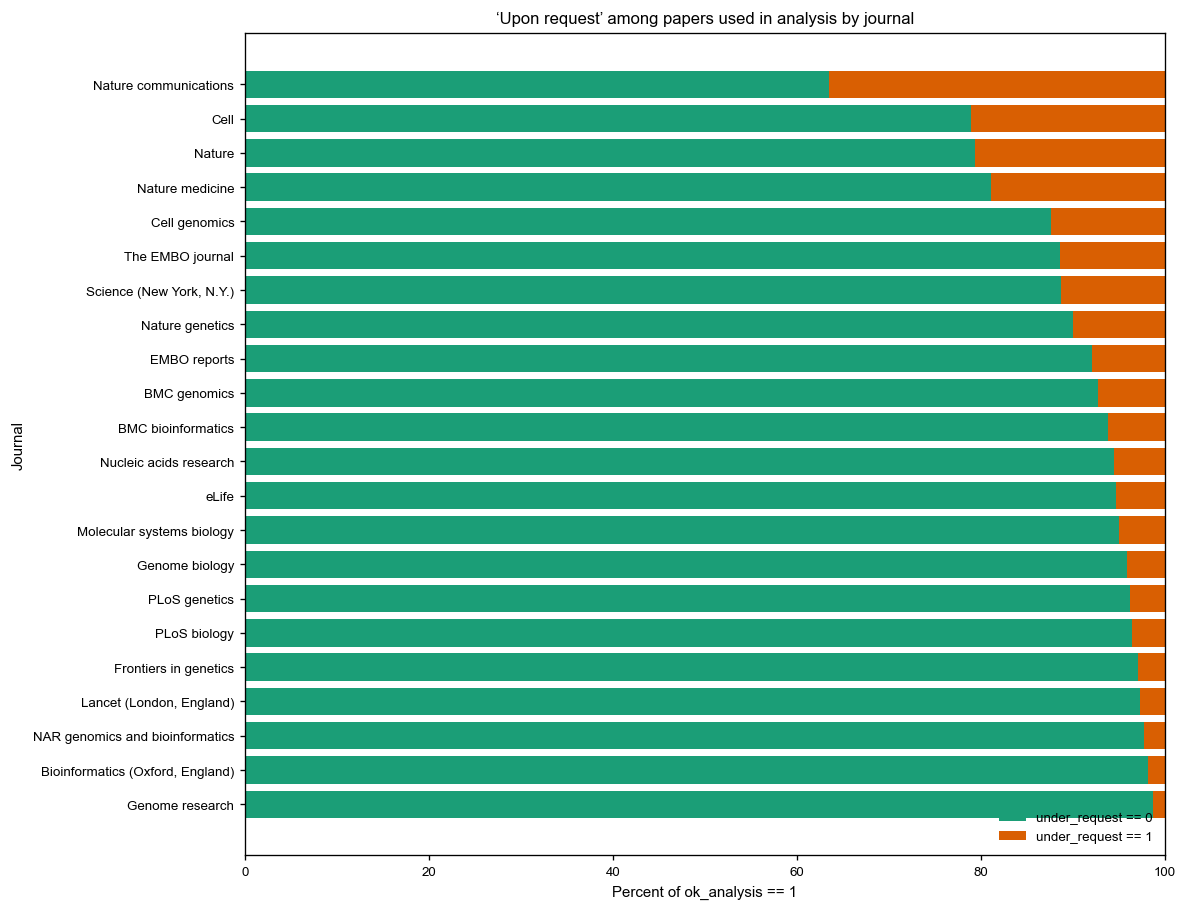

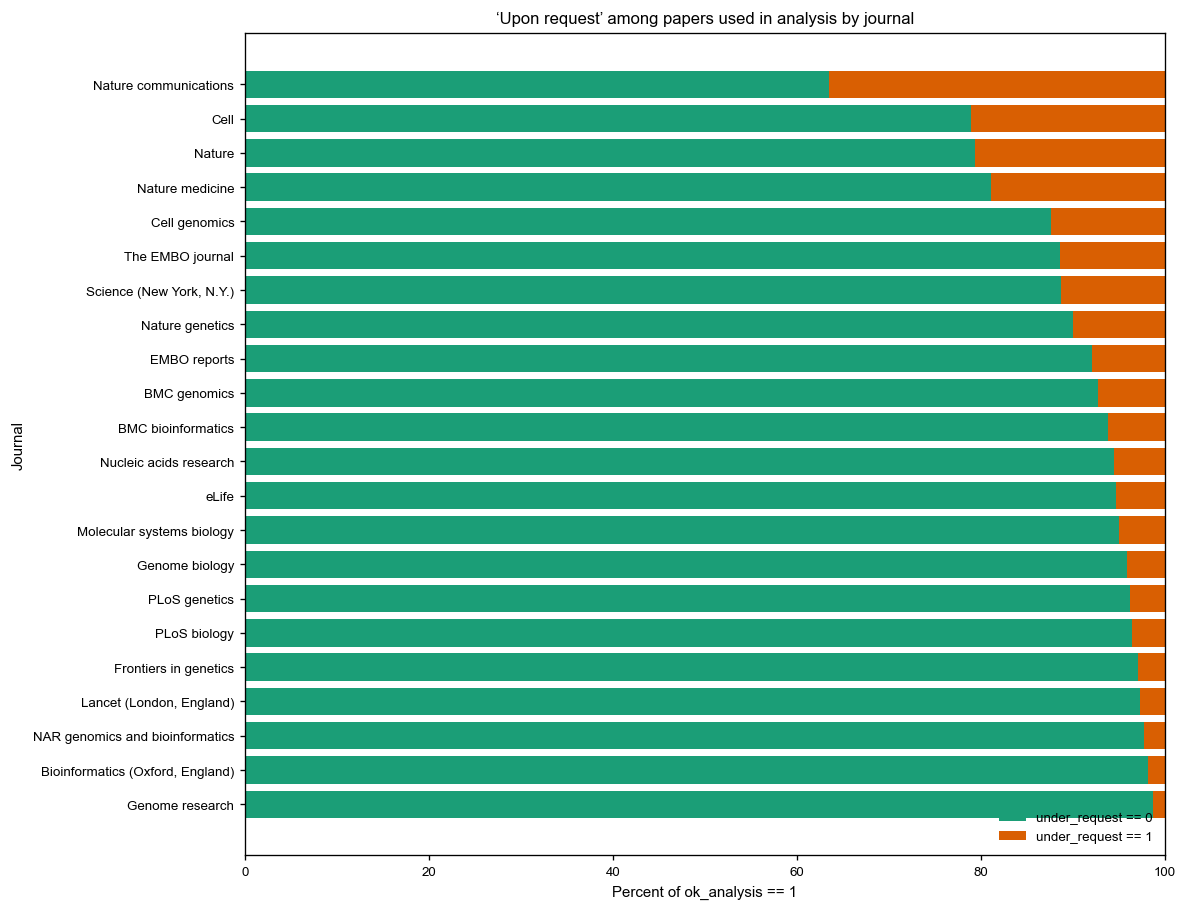

In [381]:
# Cell 6 – P4: Among ok_analysis == 1, under_request percent per journal
# Outputs TSV + PNG + PDF in 4.analyses/upon_request/under_request_pct_by_journal/.

if "journal" not in df.columns:
    raise ValueError("Expected a 'journal' column in meta_under_request_tagged.tsv")

df_ok = df[df["ok_analysis_num"] == 1].copy()

counts_j = (
    df_ok.groupby(["journal", "under_request_num"], dropna=False)
         .size()
         .reset_index(name="n")
)

pivot_j = (
    counts_j
    .pivot(index="journal", columns="under_request_num", values="n")
    .fillna(0)
    .rename(columns={0: "not_ur", 1: "ur"})
)

pivot_j["total"] = pivot_j["not_ur"] + pivot_j["ur"]
pivot_j["not_ur_pct"] = 100.0 * pivot_j["not_ur"] / pivot_j["total"].replace(0, np.nan)
pivot_j["ur_pct"] = 100.0 * pivot_j["ur"] / pivot_j["total"].replace(0, np.nan)

# Sort journals by share of under_request == 1, then by total
pivot_j = pivot_j.sort_values(
    by=["ur_pct", "total"],
    ascending=[False, False],
)

pivot_j_reset = pivot_j.reset_index()
pivot_j_reset.to_csv(
    out_upon
    / "under_request_pct_by_journal"
    / "under_request_pct_by_journal.tsv",
    sep="\t",
    index=False,
)

pivot_j_reset.head()


# Plot

fig_height = max(6, 0.35 * len(pivot_j_reset))
fig, ax = plt.subplots(figsize=(10, fig_height))

y = np.arange(len(pivot_j_reset))
labels = pivot_j_reset["journal"]

base = pivot_j_reset["not_ur_pct"].fillna(0)
top = pivot_j_reset["ur_pct"].fillna(0)

ax.barh(y, base, label="under_request == 0")
ax.barh(y, top, left=base, label="under_request == 1")

ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.invert_yaxis()

ax.set_xlabel("Percent of ok_analysis == 1")
ax.set_ylabel("Journal")
ax.set_xlim(0, 100)
ax.set_title("‘Upon request’ among papers used in analysis by journal")

ax.legend(frameon=False, loc="lower right")
plt.tight_layout()

fig.savefig(
    out_upon
    / "under_request_pct_by_journal"
    / "under_request_pct_by_journal.png",
    dpi=300,
)
fig.savefig(
    out_upon
    / "under_request_pct_by_journal"
    / "under_request_pct_by_journal.pdf",
)

fig


Journals differ markedly in their reliance on “upon request” language. For example, approximately 36 % of analysable Nature Communications articles contain a UR statement, versus less than 5 % in Genome Research

## 4. Genuine versus non genuine and restricted "under request" statements

Not all "data available upon request" statements are equivalent. Some clearly correspond to genuine access routes, for instance sharing biological materials (for example plasmids, strains, constructs) these are encoded as `genuine == 1`. Within this group, a subset of statements explicitly describe restricted or controlled access regimes (for example data sharing agreements, hospital non-disclosure agreements, controlled-access repositories); these are additionally flagged as `restricted == 1`. All remaining UR statements are considered non genuine (`genuine == 0`), because the wording is vague, non committal, or does not describe a verifiable mechanism for obtaining the data or materials.

Using the `genuine` and `under_request` flags, we refine the global counts into three mutually exclusive categories:

1. **Genuine UR statements**  
   `under_request == 1` and `genuine == 1`.  
   These statements typically offer a concrete route to access data or materials (for example sharing datasets subject to reasonable safeguards, or providing plasmids, strains, primers or blueprints upon request). Restricted-access cases (`restricted == 1`) form a subset of this category and are treated separately where indicated.

2. **Non genuine UR statements**  
   `under_request == 1` and `genuine == 0`.  
   Here the phrase "available upon request" appears in the text, but without a clear, reproducible access path. 

3. **Open (no UR wording)**  
   `under_request == 0`.  
   These articles do not contain any "upon request" wording. Data and materials may be shared via public repositories, source data files, or other open mechanisms, or they may not be shared at all. This category is defined solely by the absence of UR language.

We then visualise the breakdown by journal and by year using stacked barplots, showing:

- the proportion of all analysable articles that fall into each category, and  
- within the `under_request == 1` subset, the relative contributions of genuine and non genuine statements (and, where relevant, the restricted subset).



In [382]:
# New Cell 1 – Load df with genuine numeric flag

from pathlib import Path

def ensure_dir(p: Path) -> None:
    p.mkdir(parents=True, exist_ok=True)

# Reload from disk using the same logic as load_df() in 10_plots_genuine_breakdown.py
df_g = pd.read_csv(input_path, sep="\t", dtype=str, keep_default_na=False)

# Required columns
for col in ["year", "under_request", "genuine"]:
    if col not in df_g.columns:
        raise ValueError(f"Expected column '{col}' in the input TSV.")

# Normalize types
df_g["year"] = pd.to_numeric(df_g["year"], errors="coerce")
df_g["under_request_num"] = (
    pd.to_numeric(df_g["under_request"], errors="coerce")
    .fillna(0)
    .astype(int)
)
df_g["genuine_num"] = (
    pd.to_numeric(df_g["genuine"], errors="coerce")
    .fillna(0)
    .astype(int)
)

# ok_analysis flag (same fallback order as in the script)
if "ok_analysis" in df_g.columns:
    df_g["ok_analysis_num"] = (
        pd.to_numeric(df_g["ok_analysis"], errors="coerce")
        .fillna(0)
        .astype(int)
    )
elif "analysis_ok" in df_g.columns:
    df_g["ok_analysis_num"] = (
        pd.to_numeric(df_g["analysis_ok"], errors="coerce")
        .fillna(0)
        .astype(int)
    )
else:
    df_g["ok_analysis_num"] = 0

# Drop missing years and clip to analysis window
df_g = df_g.dropna(subset=["year"]).copy()
df_g["year"] = df_g["year"].astype(int)
df_g = df_g[(df_g["year"] >= YEAR_MIN) & (df_g["year"] <= YEAR_MAX)].copy()

df_g[["year", "ok_analysis_num", "under_request_num", "genuine_num"]].head()


,year,ok_analysis_num,under_request_num,genuine_num
0,2010,1,0,0
1,2010,1,0,0
2,2010,1,0,0
3,2010,1,0,0
4,2010,1,0,0


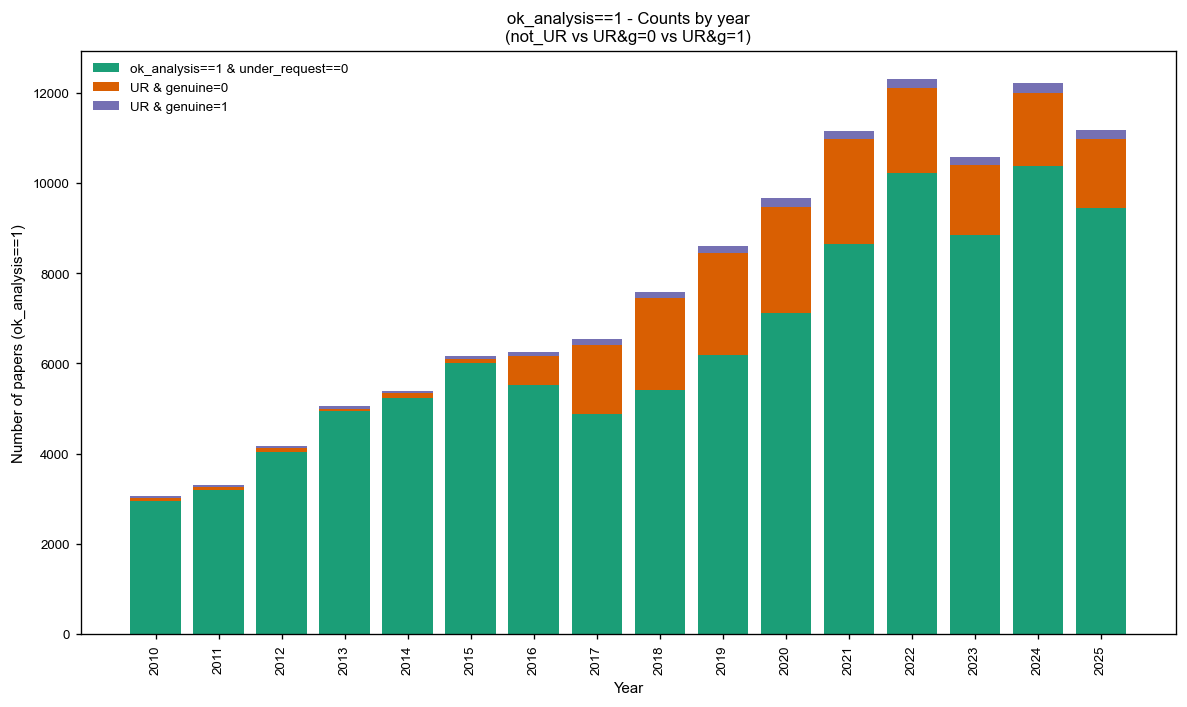

In [383]:
# New Cell 2 – G2: Counts per year (not_UR vs UR & g=0 vs UR & g=1)

out_dir_counts = out_upon / "under_request_genuine"

ensure_dir(out_dir_counts)

df_ok = df_g[df_g["ok_analysis_num"] == 1].copy()

# Totals among ok_analysis==1
ok_total = df_ok.groupby("year").size().rename("ok_analysis_1_total")

# Breakdowns among ok_analysis==1
not_ur = (
    df_ok[df_ok["under_request_num"] == 0]
    .groupby("year")
    .size()
    .rename("not_ur")
)
ur_g1 = (
    df_ok[(df_ok["under_request_num"] == 1) & (df_ok["genuine_num"] == 1)]
    .groupby("year")
    .size()
    .rename("ur_genuine_1")
)
ur_g0 = (
    df_ok[(df_ok["under_request_num"] == 1) & (df_ok["genuine_num"] == 0)]
    .groupby("year")
    .size()
    .rename("ur_genuine_0")
)

years = pd.Series(range(YEAR_MIN, YEAR_MAX + 1), name="year")
summary_g2 = pd.DataFrame({"year": years})
for s in (ok_total, not_ur, ur_g0, ur_g1):
    summary_g2 = summary_g2.merge(s.reset_index(), on="year", how="left")

# Fill + types
for c in ["ok_analysis_1_total", "not_ur", "ur_genuine_0", "ur_genuine_1"]:
    summary_g2[c] = summary_g2[c].fillna(0).astype(int)

# Save TSV
summary_g2.to_csv(
    out_dir_counts / "under_request_genuine_count_by_year.tsv",
    sep="\t",
    index=False,
)

# Plot (same structure as the script)
fig, ax = plt.subplots(figsize=(10, 6))

x = summary_g2["year"].values
base = summary_g2["not_ur"].values
mid = summary_g2["ur_genuine_0"].values
top = summary_g2["ur_genuine_1"].values

ax.bar(x, base, label="ok_analysis==1 & under_request==0")
ax.bar(x, mid, bottom=base, label="UR & genuine=0")
ax.bar(x, top, bottom=base + mid, label="UR & genuine=1")

ax.set_xlabel("Year")
ax.set_ylabel("Number of papers (ok_analysis==1)")
ax.set_title("ok_analysis==1 - Counts by year\n(not_UR vs UR&g=0 vs UR&g=1)")
ax.set_xticks(x)
ax.set_xticklabels(x, rotation=90)
ax.legend(frameon=False)
plt.tight_layout()

fig.savefig(out_dir_counts / "under_request_genuine_count_by_year.png", dpi=300)
fig.savefig(out_dir_counts / "under_request_genuine_count_by_year.pdf")
plt.close(fig)

fig


Over time, the share of UR statements judged as genuine (with or without restrictions) increases, but a non-trivial fraction of UR language remains non-genuine or explicitly restricted in recent years

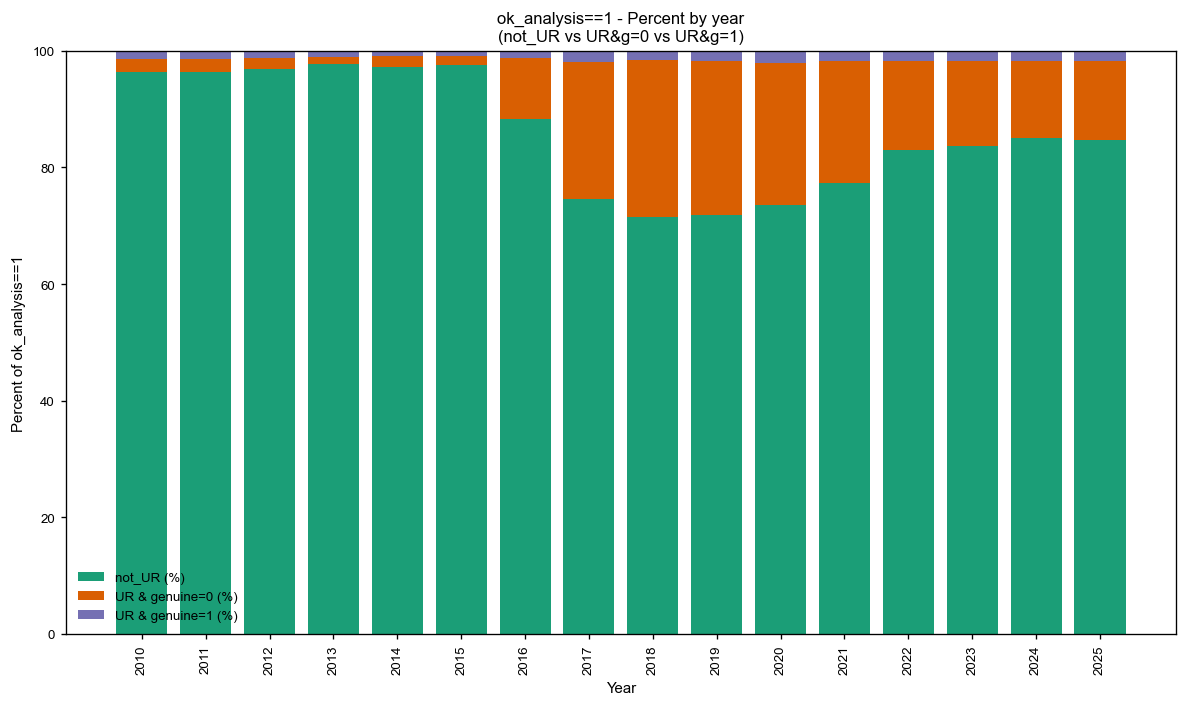

In [384]:
# New Cell 3 – G3: Percent per year (not_UR vs UR & g=0 vs UR & g=1)

out_dir_pct_year = out_upon / "under_request_genuine_pct_by_year"
ensure_dir(out_dir_pct_year)

summary_g3 = summary_g2.copy()

denom = summary_g3["ok_analysis_1_total"].replace(0, np.nan)
summary_g3["not_ur_pct"] = 100.0 * (summary_g3["not_ur"] / denom)
summary_g3["ur_g0_pct"] = 100.0 * (summary_g3["ur_genuine_0"] / denom)
summary_g3["ur_g1_pct"] = 100.0 * (summary_g3["ur_genuine_1"] / denom)

summary_g3.to_csv(
    out_dir_pct_year / "under_request_genuine_pct_by_year.tsv",
    sep="\t",
    index=False,
)

fig, ax = plt.subplots(figsize=(10, 6))

x = summary_g3["year"].values
b = summary_g3["not_ur_pct"].fillna(0).values
m = summary_g3["ur_g0_pct"].fillna(0).values
t = summary_g3["ur_g1_pct"].fillna(0).values

ax.bar(x, b, label="not_UR (%)")
ax.bar(x, m, bottom=b, label="UR & genuine=0 (%)")
ax.bar(x, t, bottom=b + m, label="UR & genuine=1 (%)")

ax.set_xlabel("Year")
ax.set_ylabel("Percent of ok_analysis==1")
ax.set_title("ok_analysis==1 - Percent by year\n(not_UR vs UR&g=0 vs UR&g=1)")
ax.set_xticks(x)
ax.set_xticklabels(x, rotation=90)
ax.set_ylim(0, 100)
ax.legend(frameon=False)
plt.tight_layout()

fig.savefig(out_dir_pct_year / "under_request_genuine_pct_by_year.png", dpi=300)
fig.savefig(out_dir_pct_year / "under_request_genuine_pct_by_year.pdf")
plt.close(fig)

fig 


Over time, the share of UR statements judged as genuine (with or without restrictions) increases, but a non-trivial fraction of UR language remains non-genuine or explicitly restricted in recent years

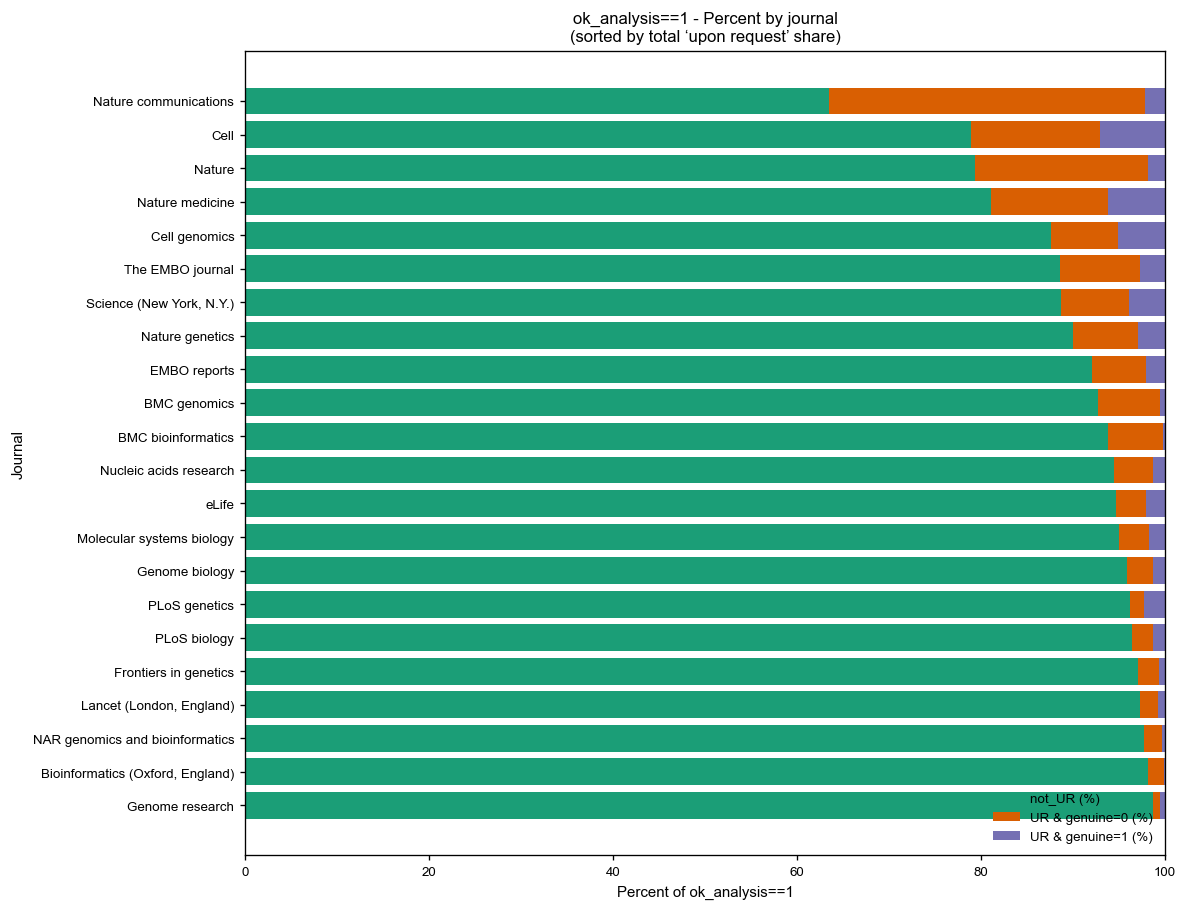

In [385]:
# New Cell 4 – G4: Percent by journal (horizontal, sorted by total UR share)

out_dir_pct_journal = out_upon / "under_request_genuine_pct_by_journal"
ensure_dir(out_dir_pct_journal)

if "journal" not in df_g.columns:
    raise ValueError("Expected a 'journal' column in the input TSV.")

df_ok = df_g[df_g["ok_analysis_num"] == 1].copy()

ok_total_j = df_ok.groupby("journal", dropna=False).size().rename("ok_analysis_1_total")
not_ur_j = (
    df_ok[df_ok["under_request_num"] == 0]
    .groupby("journal", dropna=False)
    .size()
    .rename("not_ur")
)
ur_g1_j = (
    df_ok[(df_ok["under_request_num"] == 1) & (df_ok["genuine_num"] == 1)]
    .groupby("journal", dropna=False)
    .size()
    .rename("ur_genuine_1")
)
ur_g0_j = (
    df_ok[(df_ok["under_request_num"] == 1) & (df_ok["genuine_num"] == 0)]
    .groupby("journal", dropna=False)
    .size()
    .rename("ur_genuine_0")
)

summary_j = pd.concat([ok_total_j, not_ur_j, ur_g0_j, ur_g1_j], axis=1).fillna(0)

for c in ["ok_analysis_1_total", "not_ur", "ur_genuine_0", "ur_genuine_1"]:
    summary_j[c] = summary_j[c].astype(int)

denom_j = summary_j["ok_analysis_1_total"].replace(0, np.nan)
summary_j["not_ur_pct"] = 100.0 * (summary_j["not_ur"] / denom_j)
summary_j["ur_g0_pct"] = 100.0 * (summary_j["ur_genuine_0"] / denom_j)
summary_j["ur_g1_pct"] = 100.0 * (summary_j["ur_genuine_1"] / denom_j)
summary_j["total_ur_pct"] = summary_j["ur_g0_pct"] + summary_j["ur_g1_pct"]

# Sort by total UR share, then by total ok_analysis==1
summary_j = summary_j.sort_values(
    by=["total_ur_pct", "ok_analysis_1_total"],
    ascending=[False, False],
)

summary_j_reset = summary_j.reset_index()  # restore journal as a column

summary_j_reset.to_csv(
    out_dir_pct_journal / "under_request_genuine_pct_by_journal.tsv",
    sep="\t",
    index=False,
)

# Plot
fig_height = max(6, 0.35 * len(summary_j_reset))
fig, ax = plt.subplots(figsize=(10, fig_height))

y = np.arange(len(summary_j_reset))
labels = summary_j_reset["journal"].astype(str).values

b0 = summary_j_reset["not_ur_pct"].fillna(0).values
b1 = summary_j_reset["ur_g0_pct"].fillna(0).values
b2 = summary_j_reset["ur_g1_pct"].fillna(0).values

ax.barh(y, b0, label="not_UR (%)")
ax.barh(y, b1, left=b0, label="UR & genuine=0 (%)")
ax.barh(y, b2, left=b0 + b1, label="UR & genuine=1 (%)")

ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.invert_yaxis()

ax.set_xlabel("Percent of ok_analysis==1")
ax.set_ylabel("Journal")
ax.set_title("ok_analysis==1 - Percent by journal\n(sorted by total ‘upon request’ share)")
ax.set_xlim(0, 100)
ax.legend(frameon=False, loc="lower right")
plt.tight_layout()

fig.savefig(out_dir_pct_journal / "under_request_genuine_pct_by_journal.png", dpi=300)
fig.savefig(out_dir_pct_journal / "under_request_genuine_pct_by_journal.pdf")
plt.close(fig)

fig


### Builds the under_request_by_journal plot(s) so it:
- Uses percent of ok_analysis == 1 (like your attached plot),
- Also makes a raw count version,
- Adds numeric labels on the bars,
- Writes a single TSV with counts and percents,
- Saves everything in 4.analyses/upon_request/under_request_by_journal.

In [386]:
from pathlib import Path
import numpy as np

def ensure_dir(p: Path) -> None:
    p.mkdir(parents=True, exist_ok=True)

# Output folder
out_dir_ubj = out_upon / "under_request_by_journal"
ensure_dir(out_dir_ubj)

# Work on papers actually used in the analysis
df_ok = df_g[df_g["ok_analysis_num"] == 1].copy()

if "journal" not in df_ok.columns:
    raise ValueError("Expected a 'journal' column in the input TSV.")

# Counts by journal and under_request flag
counts_j = (
    df_ok.groupby(["journal", "under_request_num"], dropna=False)
         .size()
         .reset_index(name="n")
)

# Pivot to have one row per journal, columns: n_not_ur, n_ur
pivot_j = (
    counts_j
    .pivot(index="journal", columns="under_request_num", values="n")
    .fillna(0)
    .rename(columns={0: "n_not_ur", 1: "n_ur"})
)

# Total ok_analysis == 1 per journal
pivot_j["n_total_ok"] = pivot_j["n_not_ur"] + pivot_j["n_ur"]

# Percents relative to ok_analysis == 1 for that journal
denom = pivot_j["n_total_ok"].replace(0, np.nan)
pivot_j["not_ur_pct"] = 100.0 * pivot_j["n_not_ur"] / denom
pivot_j["ur_pct"] = 100.0 * pivot_j["n_ur"] / denom

# Sort journals by UR percent, then by total number of papers
pivot_j = pivot_j.sort_values(
    by=["ur_pct", "n_total_ok"],
    ascending=[False, False],
)

summary_ubj = pivot_j.reset_index()  # restore journal column

# Save TSV with counts and percents
summary_ubj.to_csv(
    out_dir_ubj / "under_request_by_journal.tsv",
    sep="\t",
    index=False,
)

summary_ubj.head()


under_request_num,journal,n_not_ur,n_ur,n_total_ok,not_ur_pct,ur_pct
0,Nature communications,26427,15196,41623,63.491339,36.508661
1,Cell,500,134,634,78.864353,21.135647
2,Nature,3368,875,4243,79.377799,20.622201
3,Nature medicine,843,197,1040,81.057692,18.942308
4,Cell genomics,311,44,355,87.605634,12.394366


### Plot : percent stacked barh with numbers

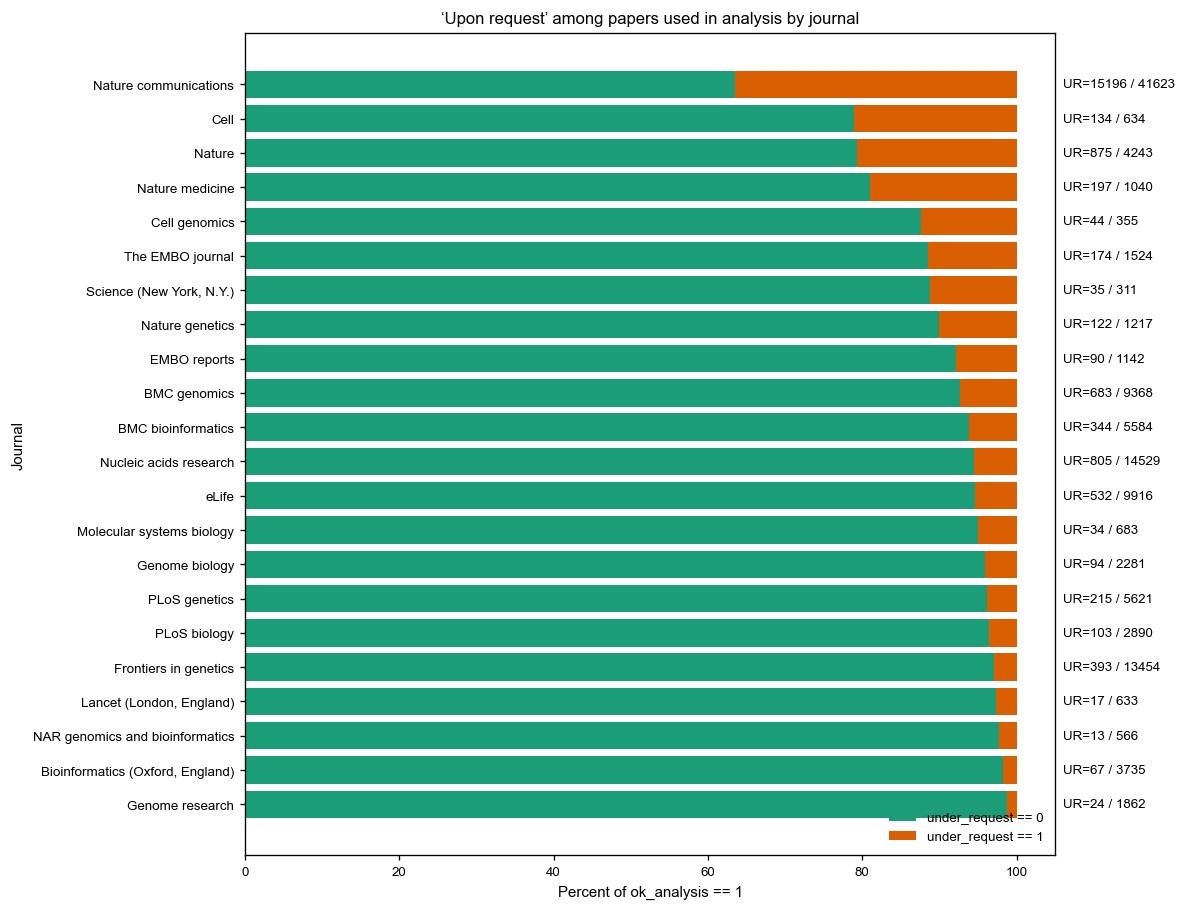

In [387]:
fig_height = max(6, 0.35 * len(summary_ubj))
fig, ax = plt.subplots(figsize=(10, fig_height))

y = np.arange(len(summary_ubj))
labels = summary_ubj["journal"].astype(str).values

b0 = summary_ubj["not_ur_pct"].fillna(0).values
b1 = summary_ubj["ur_pct"].fillna(0).values
total_pct = b0 + b1  # should be 100 or close

# under_request == 0 and == 1
bars_not_ur = ax.barh(y, b0, label="under_request == 0")
bars_ur = ax.barh(y, b1, left=b0, label="under_request == 1")

ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.invert_yaxis()

ax.set_xlabel("Percent of ok_analysis == 1")
ax.set_ylabel("Journal")
ax.set_title("‘Upon request’ among papers used in analysis by journal")

# X limit slightly above max total percent
max_x = float(np.nanmax(total_pct)) if len(total_pct) else 0.0
ax.set_xlim(0, max(5.0, max_x * 1.05))

# Add numbers at end of each bar: show counts, for example "UR=n_ur / total=n_total"
for i, yy in enumerate(y):
    n_ur_i = summary_ubj["n_ur"].iloc[i]
    n_tot_i = summary_ubj["n_total_ok"].iloc[i]
    pct_i = total_pct[i]
    if np.isfinite(pct_i) and pct_i > 0:
        ax.text(
            pct_i + max_x * 0.06,
            yy,
            f"UR={n_ur_i} / {n_tot_i}",
            va="center",
            ha="left",
            fontsize=8,
        )

ax.legend(frameon=False, loc="lower right")
plt.tight_layout()

fig.savefig(out_dir_ubj / "under_request_by_journal_pct.png", dpi=300)
fig.savefig(out_dir_ubj / "under_request_by_journal_pct.pdf")
plt.close(fig)

fig

### Plot: raw counts stacked bar, same order, with numbers

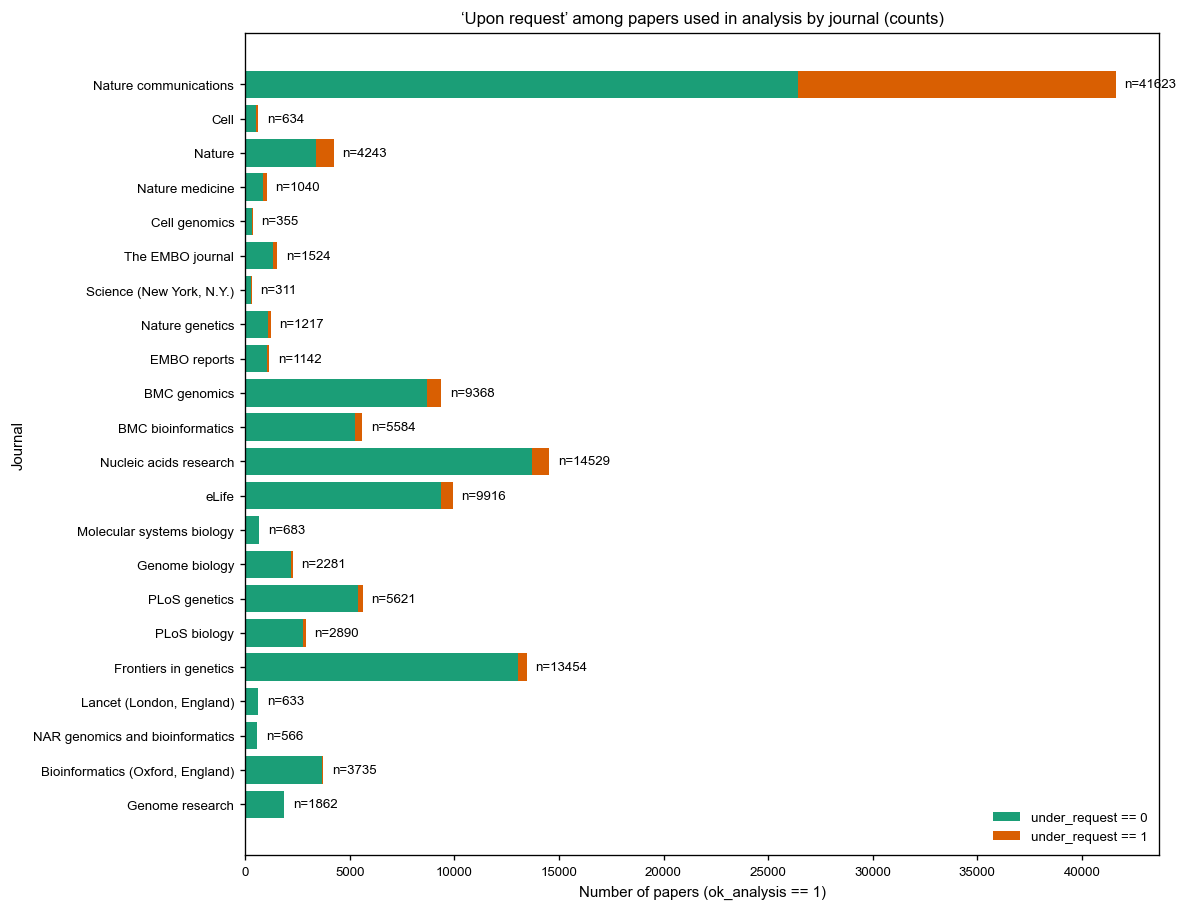

In [388]:
fig_height = max(6, 0.35 * len(summary_ubj))
fig, ax = plt.subplots(figsize=(10, fig_height))

y = np.arange(len(summary_ubj))
labels = summary_ubj["journal"].astype(str).values

c0 = summary_ubj["n_not_ur"].values
c1 = summary_ubj["n_ur"].values
c_tot = summary_ubj["n_total_ok"].values

bars_not_ur = ax.barh(y, c0, label="under_request == 0")
bars_ur = ax.barh(y, c1, left=c0, label="under_request == 1")

ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.invert_yaxis()

ax.set_xlabel("Number of papers (ok_analysis == 1)")
ax.set_ylabel("Journal")
ax.set_title("‘Upon request’ among papers used in analysis by journal (counts)")

max_x_counts = float(np.nanmax(c_tot)) if len(c_tot) else 0.0
ax.set_xlim(0, max(5.0, max_x_counts * 1.05))

# Add total counts at end of each bar
for i, yy in enumerate(y):
    n_tot_i = c_tot[i]
    right_edge = c0[i] + c1[i]
    if np.isfinite(right_edge) and right_edge > 0:
        ax.text(
            right_edge + max_x_counts * 0.01,
            yy,
            f"n={n_tot_i}",
            va="center",
            ha="left",
            fontsize=8,
        )

ax.legend(frameon=False, loc="lower right")
plt.tight_layout()

fig.savefig(out_dir_ubj / "under_request_by_journal_counts.png", dpi=300)
fig.savefig(out_dir_ubj / "under_request_by_journal_counts.pdf")
plt.close(fig)

fig


Proportion of UR statementm by journal, with genuine info

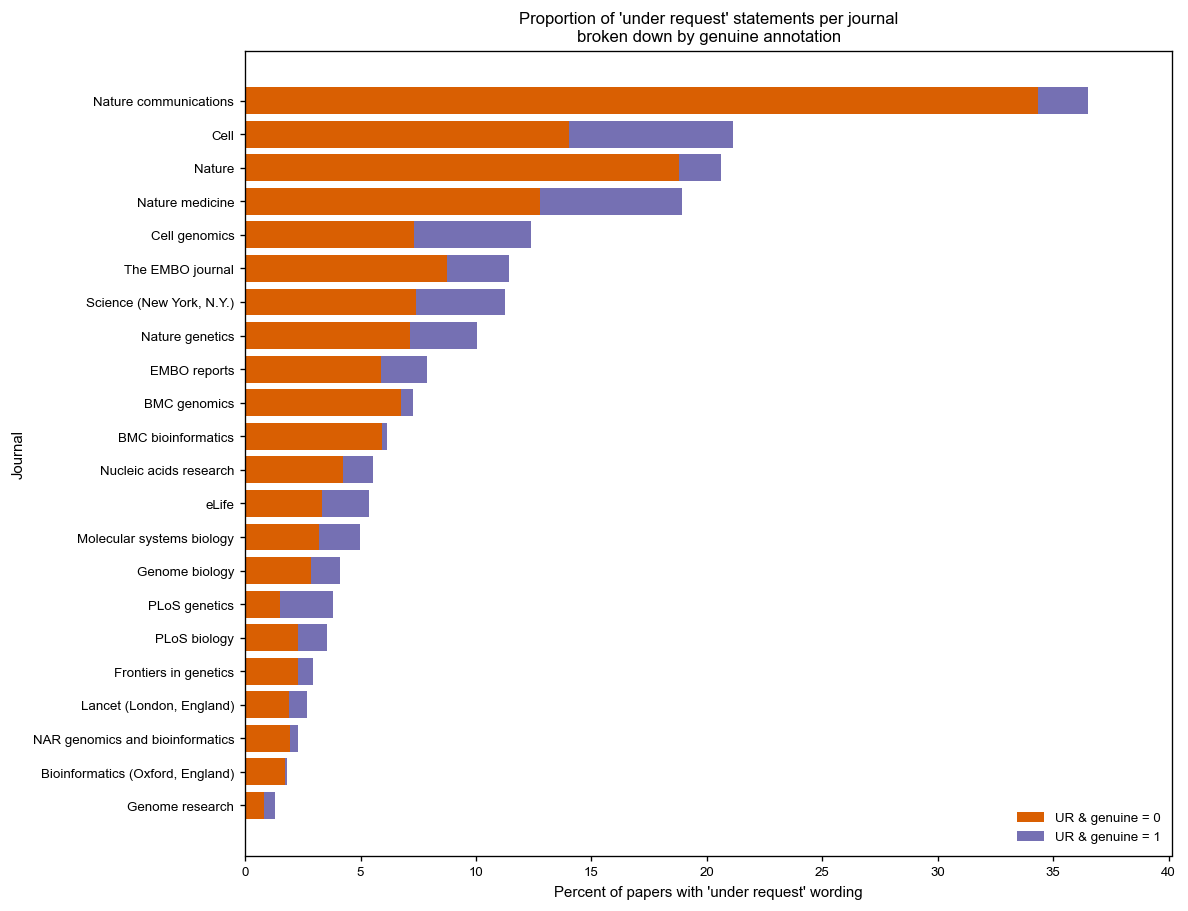

In [389]:
from pathlib import Path
import numpy as np

def ensure_dir(p: Path) -> None:
    p.mkdir(parents=True, exist_ok=True)

# Output folder for this plot
out_dir_ubj = out_upon / "under_request_by_journal"
ensure_dir(out_dir_ubj)

# Work on the analysis subset (ok_analysis == 1), as in 10_plots_genuine_breakdown.py
df_ok = df_g[df_g["ok_analysis_num"] == 1].copy()

# Total papers per journal
total_j = df_ok.groupby("journal", dropna=False).size().rename("n_total")

# All UR per journal
ur_total_j = (
    df_ok[df_ok["under_request_num"] == 1]
    .groupby("journal", dropna=False)
    .size()
    .rename("n_ur")
)

# UR & genuine == 1 per journal
ur_g1_j = (
    df_ok[(df_ok["under_request_num"] == 1) & (df_ok["genuine_num"] == 1)]
    .groupby("journal", dropna=False)
    .size()
    .rename("n_ur_genuine")
)

# Combine and derive UR & genuine == 0
summary_ubj = pd.concat([total_j, ur_total_j, ur_g1_j], axis=1).fillna(0).astype(int)
summary_ubj["n_ur_g0"] = (summary_ubj["n_ur"] - summary_ubj["n_ur_genuine"]).clip(lower=0)

# Percent of *all papers* in that journal that are UR & g=0 / UR & g=1
denom = summary_ubj["n_total"].replace(0, np.nan)
summary_ubj["ur_g0_pct"] = 100.0 * summary_ubj["n_ur_g0"] / denom
summary_ubj["ur_g1_pct"] = 100.0 * summary_ubj["n_ur_genuine"] / denom
summary_ubj["ur_total_pct"] = summary_ubj["ur_g0_pct"] + summary_ubj["ur_g1_pct"]

# Sort journals by total UR share (like the original under_request_by_journal plot)
summary_ubj = summary_ubj.sort_values("ur_total_pct", ascending=False)
summary_ubj_reset = summary_ubj.reset_index()

# Save TSV
summary_ubj_reset.to_csv(
    out_dir_ubj / "under_request_by_journal_genuine.tsv",
    sep="\t",
    index=False,
)

# Plot: proportion of UR, split into genuine=0 vs genuine=1
fig_height = max(6, 0.35 * len(summary_ubj_reset))
fig, ax = plt.subplots(figsize=(10, fig_height))

y = np.arange(len(summary_ubj_reset))
labels = summary_ubj_reset["journal"].astype(str).values

# UR & genuine = 0 (non-genuine UR)
b0 = summary_ubj_reset["ur_g0_pct"].fillna(0).values
# UR & genuine = 1 (genuine UR)
b1 = summary_ubj_reset["ur_g1_pct"].fillna(0).values

# Colors:
#   UR & g=0  -> orange (C1)
#   UR & g=1  -> green (C2)
ax.barh(y, b0, label="UR & genuine = 0", color="C1")
ax.barh(y, b1, left=b0, label="UR & genuine = 1", color="C2")

ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.invert_yaxis()

ax.set_xlabel("Percent of papers with 'under request' wording")
ax.set_ylabel("Journal")
ax.set_title("Proportion of 'under request' statements per journal\nbroken down by genuine annotation")

# X-axis up to slightly above max UR share
max_x = float(np.nanmax(summary_ubj_reset["ur_total_pct"])) if len(summary_ubj_reset) else 0
ax.set_xlim(0, max(5, max_x * 1.1))

ax.legend(frameon=False, loc="lower right")
plt.tight_layout()

fig.savefig(out_dir_ubj / "under_request_by_journal_genuine.png", dpi=300)
fig.savefig(out_dir_ubj / "under_request_by_journal_genuine.pdf")
plt.close(fig)

fig


### A TSV with full counts and percentages per journal, including the restricted subset.

A bar plot where:

- Each bar length is the total percent of papers with UR in that journal.
- The bar is split into:
- UR & genuine = 0 (orange),
- UR & genuine = 1, not restricted (green),
- UR & restricted = 1 (red).

The label n=... at the right of each bar shows the total number of UR papers in that journal.

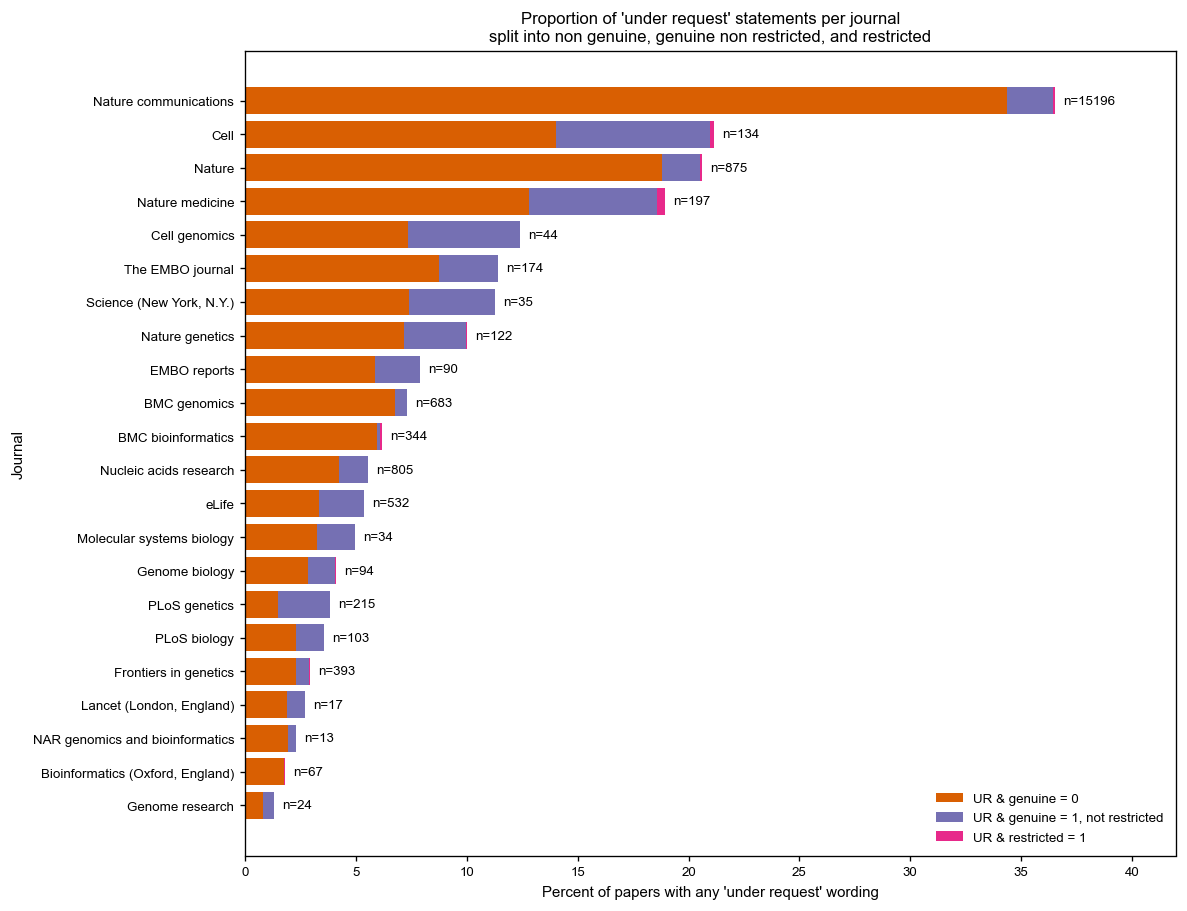

In [390]:
from pathlib import Path
import numpy as np

def ensure_dir(p: Path) -> None:
    p.mkdir(parents=True, exist_ok=True)

# Output folder
out_dir_ubj = out_upon / "under_request_by_journal"
ensure_dir(out_dir_ubj)

# Make sure restricted_num exists
if "restricted" in df_g.columns:
    df_g["restricted_num"] = (
        pd.to_numeric(df_g["restricted"], errors="coerce")
        .fillna(0)
        .astype(int)
    )
else:
    df_g["restricted_num"] = 0

# Restrict to ok_analysis == 1, like in the other plots
df_ok = df_g[df_g["ok_analysis_num"] == 1].copy()

# Totals per journal
total_j = df_ok.groupby("journal", dropna=False).size().rename("n_total")

# UR totals
ur_total_j = (
    df_ok[df_ok["under_request_num"] == 1]
    .groupby("journal", dropna=False)
    .size()
    .rename("n_ur")
)

# UR & genuine == 1
ur_g1_j = (
    df_ok[(df_ok["under_request_num"] == 1) & (df_ok["genuine_num"] == 1)]
    .groupby("journal", dropna=False)
    .size()
    .rename("n_ur_genuine")
)

# UR & restricted == 1 (subset of genuine)
ur_restricted_j = (
    df_ok[(df_ok["under_request_num"] == 1) & (df_ok["restricted_num"] == 1)]
    .groupby("journal", dropna=False)
    .size()
    .rename("n_ur_restricted")
)

# Combine
summary_ubj = pd.concat(
    [total_j, ur_total_j, ur_g1_j, ur_restricted_j],
    axis=1,
).fillna(0).astype(int)

# UR & genuine == 0
summary_ubj["n_ur_g0"] = (
    summary_ubj["n_ur"] - summary_ubj["n_ur_genuine"]
).clip(lower=0)

# UR & genuine == 1 but NOT restricted
summary_ubj["n_ur_genuine_only"] = (
    summary_ubj["n_ur_genuine"] - summary_ubj["n_ur_restricted"]
).clip(lower=0)

# Percent of ALL papers in that journal that are UR of each type
denom = summary_ubj["n_total"].replace(0, np.nan)

summary_ubj["ur_g0_pct"] = 100.0 * summary_ubj["n_ur_g0"] / denom
summary_ubj["ur_genuine_only_pct"] = 100.0 * summary_ubj["n_ur_genuine_only"] / denom
summary_ubj["ur_restricted_pct"] = 100.0 * summary_ubj["n_ur_restricted"] / denom

summary_ubj["ur_total_pct"] = (
    summary_ubj["ur_g0_pct"]
    + summary_ubj["ur_genuine_only_pct"]
    + summary_ubj["ur_restricted_pct"]
)

# Sort journals by total UR share, then by total papers
summary_ubj = summary_ubj.sort_values(
    by=["ur_total_pct", "n_total"],
    ascending=[False, False],
)

summary_ubj_reset = summary_ubj.reset_index()  # restore journal column

# Save TSV
summary_ubj_reset.to_csv(
    out_dir_ubj / "under_request_by_journal_genuine_restricted.tsv",
    sep="\t",
    index=False,
)

# Plot
fig_height = max(6, 0.35 * len(summary_ubj_reset))
fig, ax = plt.subplots(figsize=(10, fig_height))

y = np.arange(len(summary_ubj_reset))
labels = summary_ubj_reset["journal"].astype(str).values

b0 = summary_ubj_reset["ur_g0_pct"].fillna(0).values
b1 = summary_ubj_reset["ur_genuine_only_pct"].fillna(0).values
b2 = summary_ubj_reset["ur_restricted_pct"].fillna(0).values
total_pct = summary_ubj_reset["ur_total_pct"].fillna(0).values

# Colors:
#   UR & g=0           -> orange (C1)
#   UR & g=1, not restr -> green (C2)
#   UR & restricted    -> red (C3)
ax.barh(y, b0, label="UR & genuine = 0", color="C1")
ax.barh(y, b1, left=b0, label="UR & genuine = 1, not restricted", color="C2")
ax.barh(
    y,
    b2,
    left=b0 + b1,
    label="UR & restricted = 1",
    color="C3",
)

ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.invert_yaxis()

ax.set_xlabel("Percent of papers with any 'under request' wording")
ax.set_ylabel("Journal")
ax.set_title(
    "Proportion of 'under request' statements per journal\n"
    "split into non genuine, genuine non restricted, and restricted"
)

max_x = float(np.nanmax(total_pct)) if len(total_pct) else 0.0
ax.set_xlim(0, max(5.0, max_x * 1.15))

# Add total UR counts at the end of each bar
for i, (pct, yy) in enumerate(zip(total_pct, y)):
    n_ur_i = summary_ubj_reset["n_ur"].iloc[i]
    if np.isfinite(pct) and pct > 0:
        ax.text(
            pct + max_x * 0.01,
            yy,
            f"n={n_ur_i}",
            va="center",
            ha="left",
            fontsize=8,
        )

ax.legend(frameon=False, loc="lower right")
plt.tight_layout()

fig.savefig(out_dir_ubj / "under_request_by_journal_genuine_restricted.png", dpi=300)
fig.savefig(out_dir_ubj / "under_request_by_journal_genuine_restricted.pdf")
plt.close(fig)

fig


## 6. Reproducibility and exported outputs

All analyses in this notebook are based on the metadata table `meta_under_request_tagged.tsv` generated by the main text mining pipeline. To make the results reproducible:

- Every plot is written to disk as both PDF and PNG files in the `4.analyses/upon_request` subdirectories.
- The underlying summary tables used to generate each figure (for example, counts and percentages by year and journal) are exported as TSV files alongside the plots.
- The classification logic for `under_request`, `genuine`, and `restricted` is captured in the scripts `07_parse_under_request_with_sections_restricted.py` and `08_tag_under_request_compliance.py`, which are version controlled in the `1.scripts` folder.

This notebook, together with the scripts and TSV outputs, provide a transparent and inspectable record of the analyses underlying the figures used in the main text and supplementary material.

The current notebook and the scripts `07_parse_under_request_with_sections_restricted.py` and `08_tag_under_request_compliance.py` are version-controlled in the `1.scripts` directory and archived together with the TSV outputs in Zenodo and the institutional code archive.